In [1]:
import uproot
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yahist
import mplhep as hep

from utils.analysis import Validation

plt.rcParams.update({"figure.facecolor": (1,1,1,0)})

TAG = "main"
# TAG = "max_detajj"
APPLY_EWKFIX = True

PLOTSDIR = f"/home/users/jguiang/public_html/vbswh_plots/{TAG}/val"
os.makedirs(PLOTSDIR, exist_ok=True)

In [2]:
presort_babies = sorted(glob.glob(f"../analysis/studies/vbswh/output_{TAG}/Run2/*.root"))
presort_babies = [baby for baby in presort_babies if "Lambda" not in baby]
babies = []
for baby in sorted(presort_babies, reverse=True):
    if "EWK" in baby.split("/")[-1]:
        babies.append(baby)
    else:
        babies.insert(0, baby)
        
for baby_i, baby in enumerate(babies):
    if "VBSWH_SM" in baby.split("/")[-1] in baby:
        babies.append(babies.pop(baby_i))
        break
        
babies

['../analysis/studies/vbswh/output_main/Run2/Bosons.root',
 '../analysis/studies/vbswh/output_main/Run2/SingleTop.root',
 '../analysis/studies/vbswh/output_main/Run2/TTX.root',
 '../analysis/studies/vbswh/output_main/Run2/TTbar1L.root',
 '../analysis/studies/vbswh/output_main/Run2/TTbar2L.root',
 '../analysis/studies/vbswh/output_main/Run2/VBSWH_mkW.root',
 '../analysis/studies/vbswh/output_main/Run2/VH.root',
 '../analysis/studies/vbswh/output_main/Run2/WJets.root',
 '../analysis/studies/vbswh/output_main/Run2/data.root',
 '../analysis/studies/vbswh/output_main/Run2/EWKWLep.root',
 '../analysis/studies/vbswh/output_main/Run2/VBSWH_SM.root']

In [3]:
# presort_babies = sorted(glob.glob(f"../analysis/studies/vbswh/output_{TAG}/Run2/*.root"))
# presort_babies = [baby for baby in presort_babies if "VBSWH_mkW" not in baby and "Lambda" not in baby]
# babies = []
# for baby in sorted(presort_babies, reverse=True):
#     if "EWK" in baby.split("/")[-1]:
#         babies.append(baby)
#     else:
#         babies.insert(0, baby)
        
# for baby_i, baby in enumerate(babies):
#     if "VBSWH_SM" in baby.split("/")[-1] in baby:
#         babies.append(babies.pop(baby_i))
#         break
# babies

In [4]:
# babies.remove("../analysis/studies/vbswh/output_ewkcheck_nofix/Run2/EWKWLep.root")
# babies.remove("../analysis/studies/vbswh/output_ewkcheck_nofix/Run2/EWKVOther.root")

In [5]:
if APPLY_EWKFIX:
    weight_columns=[
        "xsec_sf", "lep_id_sf", "ewkfix_sf", 
        "elec_reco_sf", "muon_iso_sf", 
        "btag_sf", "pu_sf", "prefire_sf", "trig_sf", "puid_sf"
    ]
else:
    weight_columns=[
        "xsec_sf", "lep_id_sf", 
        "elec_reco_sf", "muon_iso_sf", 
        "btag_sf", "pu_sf", "prefire_sf", "trig_sf", "puid_sf"
    ]
    PLOTSDIR=PLOTSDIR.replace(f"/{TAG}/", f"/{TAG}_nofix/")

In [6]:
vbswh = Validation(
    sig_root_files=[baby for baby in presort_babies if "VBSWH_mkW" in baby],
    bkg_root_files=[baby for baby in babies if "data" not in baby and "VBSWH" not in baby],
    data_root_files=[baby for baby in babies if "data" in baby],
    ttree_name="tree",
    weight_columns=weight_columns,
    plots_dir=PLOTSDIR,
    sample_labels = {
        "VBSWH_SM": "VBSWH (SM)", 
        "TTbar1L": r"$t\bar{t}+1\ell$",
        "TTbar2L": r"$t\bar{t}+2\ell$",
        "TTX": r"$t\bar{t}+X$",
        "SingleTop": "Single top",
        "WJets": "W+jets",
        "EWKWLep": r"EWK W$\rightarrow\ell\nu$"
    },
    reweight_column="reweights",
    stack_order=["Bosons"]
)
vbswh.df["presel_noVBS_noBVeto"] = vbswh.df.eval(
    "hbbjet_score > 0.3"
)
vbswh.df["presel_noVBS"] = vbswh.df.eval(
    "passes_bveto and hbbjet_score > 0.3"
)
vbswh.df["presel_noDetaJJ"] = vbswh.df.eval(
    "passes_bveto and M_jj > 500 and hbbjet_score > 0.3"
)
vbswh.df["presel"] = vbswh.df.eval(
    "passes_bveto and M_jj > 500 and abs_deta_jj > 3 and hbbjet_score > 0.3"
)
vbswh.df["SR_like"] = vbswh.df.eval(
    "presel_noDetaJJ and M_jj > 600 and ST > 900 and hbbjet_score > 0.9"
)

vbswh.df["regionA"] = vbswh.df.eval(
    "presel_noDetaJJ and M_jj > 600 and ST > 900 and hbbjet_score > 0.9 and abs_deta_jj > 4 and hbbjet_msoftdrop >= 150"
)
vbswh.df["regionB"] = vbswh.df.eval(
    "presel_noDetaJJ and M_jj > 600 and ST > 900 and hbbjet_score > 0.9 and abs_deta_jj <= 4 and hbbjet_msoftdrop >= 150"
)
vbswh.df["regionC"] = vbswh.df.eval(
    "presel_noDetaJJ and M_jj > 600 and ST > 900 and hbbjet_score > 0.9 and abs_deta_jj <= 4 and hbbjet_msoftdrop < 150"
)
# vbswh.make_selection("passes_bveto == True")
# vbswh.make_selection(
#     "M_jj > 1500 and abs_deta_jj > 4 and passes_bveto and ST > 1200 and hbbjet_msoftdrop > 150 and hbbjet_score < 0.9"
# )
# vbswh.make_selection(
#     "passes_bveto and hbbjet_score < 0.9"
# )
# vbswh.make_selection("passes_bveto != True")

Loading sig babies:   0%|                                                                                                                                                                                                                                 | 0/1 [00:00<?, ?it/s]/home/users/jguiang/projects/vbs/notebooks/utils/analysis.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["is_signal"] = True
/home/users/jguiang/projects/vbs/notebooks/utils/analysis.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["is_data"] = F

Loading bkg babies:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 7/8 [01:26<00:19, 19.58s/it]/home/users/jguiang/projects/vbs/notebooks/utils/analysis.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["is_signal"] = False
/home/users/jguiang/projects/vbs/notebooks/utils/analysis.py:59: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["is_data"] = 

In [7]:
vbswh.df["SR_like"] = vbswh.df.eval(
    "presel_noDetaJJ and M_jj > 600 and ST > 900 and hbbjet_score > 0.9"
)

In [9]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as clr

cmap = clr.LinearSegmentedColormap.from_list("trident", ["#182B49","#00629B", "#C69214", "#FFCD00"], N=256)
cmap.set_under("#182B49")

def colorbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    return fig.colorbar(mappable, cax=cax)

def plot_2dcorr(sel=None, sample=None, flip=False, year=None, rebin=None, data=False, 
                msd_edges=np.linspace(40, 440, 41), detajj_edges=np.linspace(0, 8, 41)):

    if sample is None:
        if data:
            df = vbswh.data_df(selection=sel)
        else:
            df = vbswh.bkg_df(selection=sel)
    else:
        df = vbswh.sample_df(sample, selection=sel)
        
    if not year is None:
        df = df[df.year.abs() == year]
        if year == 2016:
            lumi = 36.33
        elif year == 2017:
            lumi = 41.48
        elif year == 2018:
            lumi = 59.83
    else:
        lumi = 138

    hist2d = yahist.Hist2D(
        (df.abs_deta_jj, df.hbbjet_msoftdrop),
        bins=[detajj_edges, msd_edges],
        weights=df.event_weight
    )
    if flip:
        hist2d = hist2d.transpose()
    if not rebin is None:
        hist2d = hist2d.rebin(rebin)

    # Plot 2D hist
    fig, axes = plt.subplots(figsize=(11, 11))
    mpl_objs = hist2d.plot(
        ax=axes, colorbar=False, counts=False, 
        counts_formatter="{:.2f}".format, counts_fontsize=6, 
        cmap=cmap, zrange=(0, None), hide_empty=False
    );
    if flip:
        axes.set_xlabel(r"$M_{SD}$");
        axes.set_ylabel(r"$|\Delta\eta_{jj}|$");
        axes.set_ylim(bottom=0)
        hist2d.profile("x").plot(errors=True, color="white", fmt=".", label=r"$M_{SD}$ profile")
    else:
        axes.set_ylabel(r"$M_{SD}$");
        axes.set_xlabel(r"$|\Delta\eta_{jj}|$");
        axes.set_ylim(bottom=40)
        hist2d.profile("x").plot(errors=True, color="white", fmt=".", label=r"$|\Delta\eta_{jj}|$ profile")

    # Plot colorbar
    cbar = colorbar(mpl_objs[0]);
    cbar.set_label(r"Count");

    if data:
        legend = axes.legend(title="Data" if sample is None else vbswh.sample_labels.get(sample, sample))
    elif not sample is None:
        legend = axes.legend(title=vbswh.sample_labels.get(sample, sample))
    else:
        legend = axes.legend(title="All background")
        
    legend.get_title().set_color("white")
    for label in legend.get_texts():
        label.set_color("white")

    # Add CMS label
    hep.cms.label(
        "Preliminary",
        data=data,
        lumi=lumi,
        loc=0,
        ax=axes,
    );
    
    outfile = f"{PLOTSDIR}/correlation2D_1Dprofile.pdf"
    if data:
        outfile = outfile.replace(".pdf", "_data.pdf")
    if not sample is None:
        outfile = outfile.replace(".pdf", f"_{sample}.pdf")
    if flip:
        outfile = outfile.replace(".pdf", "_flipped.pdf")
    if not year is None:
        outfile = outfile.replace(".pdf", f"_{year}.pdf")
        
    print(f"Saved {outfile}")
    plt.savefig(outfile, bbox_inches="tight")
    plt.savefig(outfile.replace(".pdf", ".png"), bbox_inches="tight")
    
    return hist2d

Saved /home/users/jguiang/public_html/vbswh_plots/main/val/correlation2D_1Dprofile_data_flipped.pdf


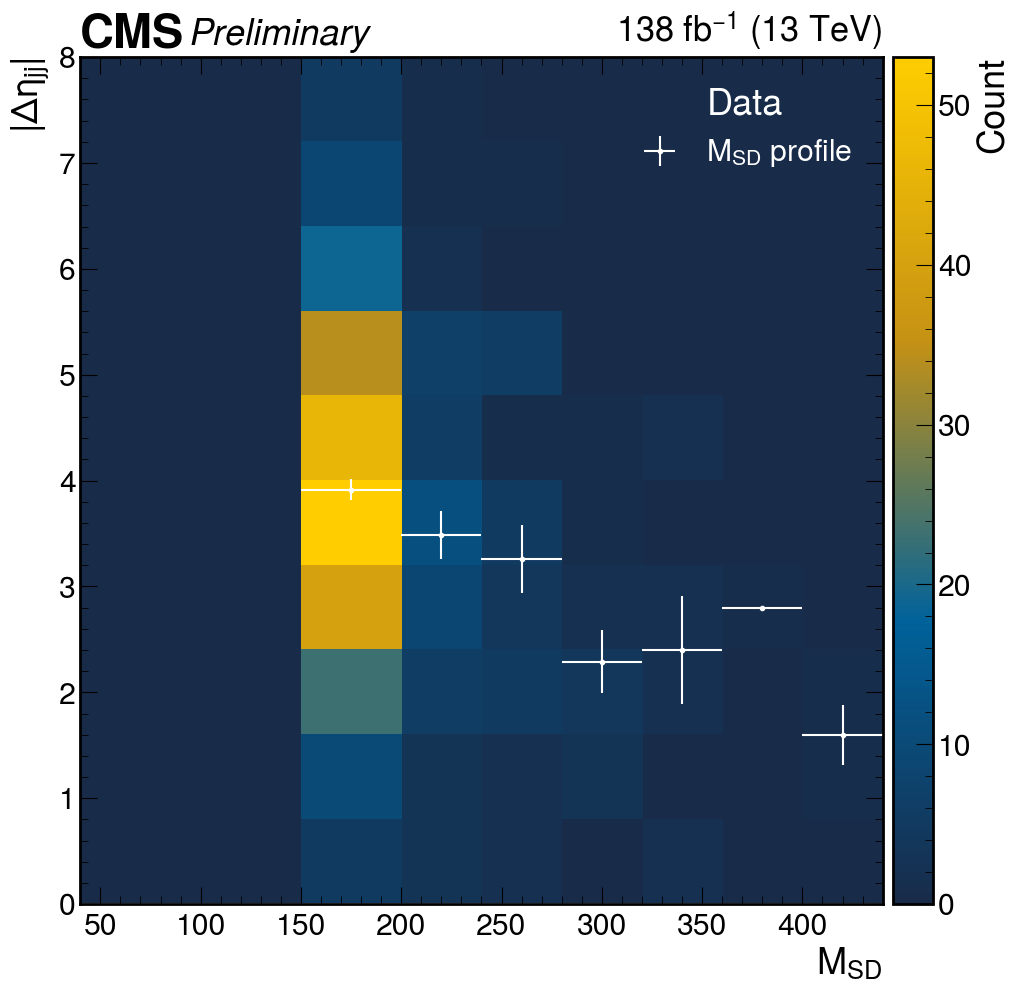

In [10]:
data_hist = plot_2dcorr(sel="SR_like and hbbjet_msoftdrop > 150", flip=True, data=True, 
                        msd_edges=[40, 50, 150, 200, 240, 280, 320, 360, 400, 440], 
                        detajj_edges=np.linspace(0, 8, 11))

Saved /home/users/jguiang/public_html/vbswh_plots/main/val/correlation2D_1Dprofile_flipped.pdf


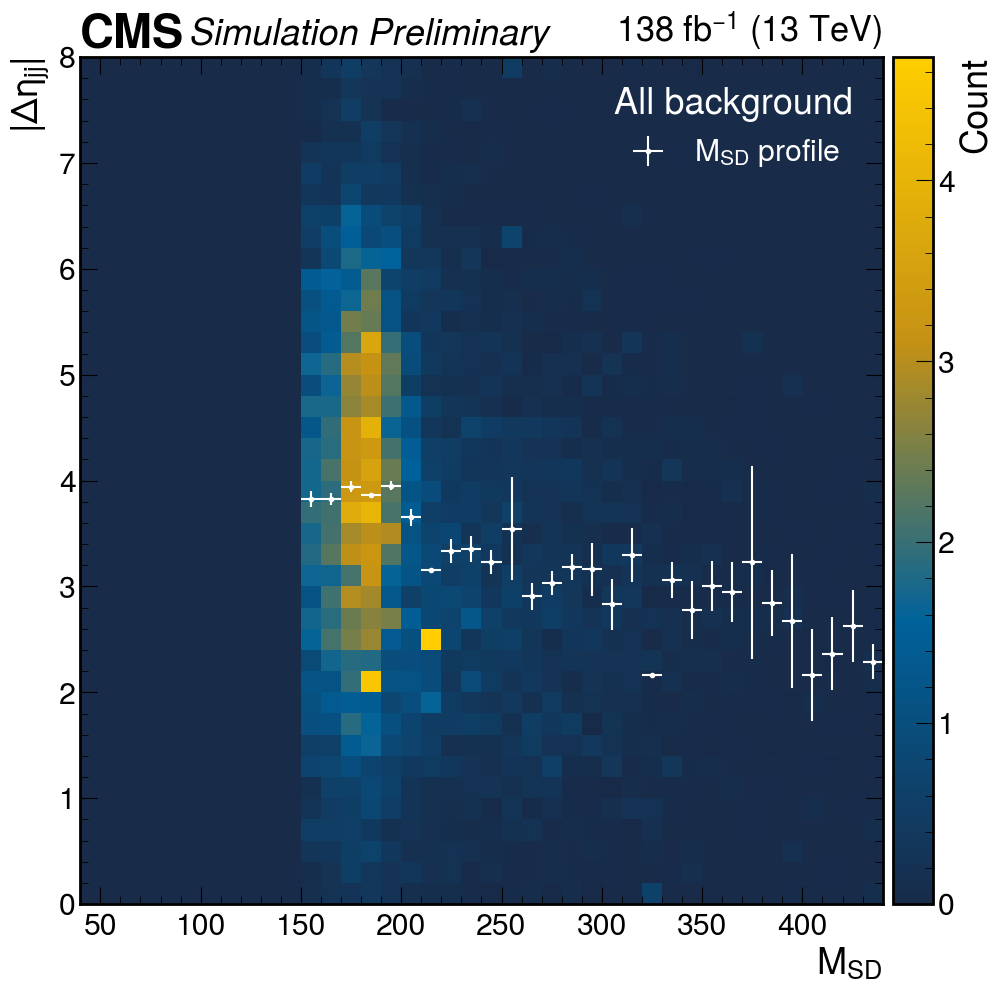

In [11]:
mc_hist = plot_2dcorr(sel="SR_like and hbbjet_msoftdrop > 150", flip=True)

Saved /home/users/jguiang/public_html/vbswh_plots/main/val/correlation2D_1Dprofile_data_vs_mc.pdf


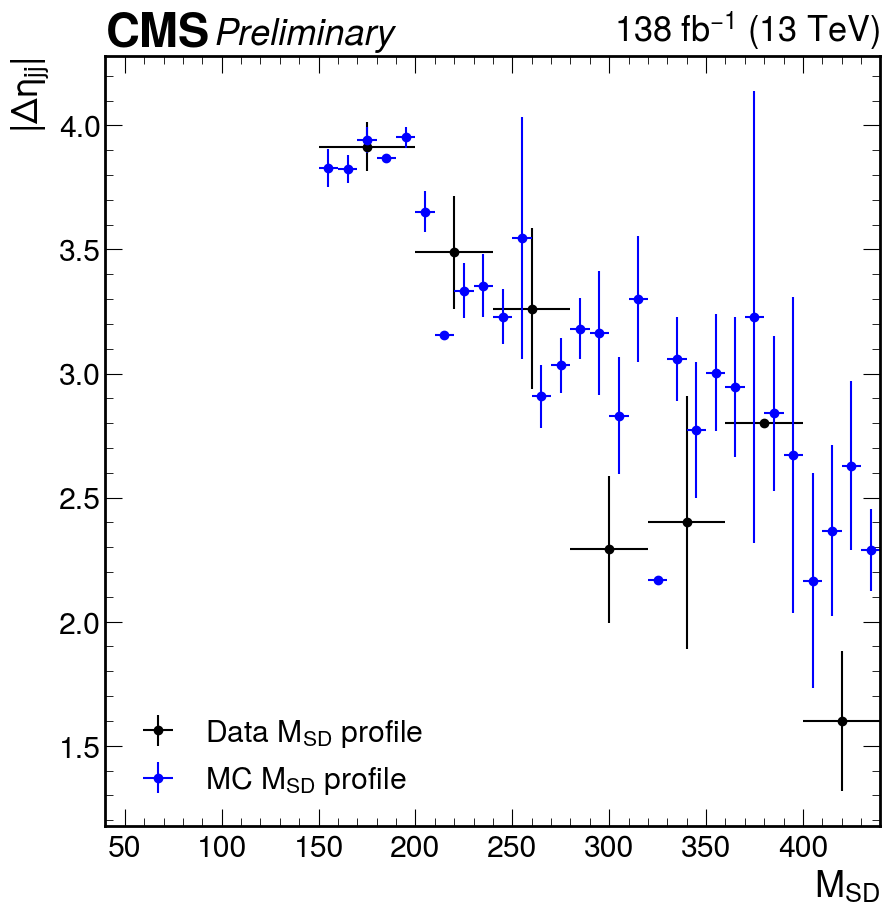

In [11]:
fig, axes = plt.subplots()

data_hist.profile().plot(ax=axes, errors=True, color="k", label="Data $M_{SD}$ profile");
mc_hist.profile().plot(ax=axes, errors=True, color="blue", label="MC $M_{SD}$ profile");

axes.set_xlabel("$M_{SD}$");
axes.set_ylabel("$|\Delta\eta_{jj}|$");

# Add CMS label
hep.cms.label(
    "Preliminary",
    data=True,
    lumi=138,
    loc=0,
    ax=axes,
);

axes.legend(loc="lower left")

outfile = f"{PLOTSDIR}/correlation2D_1Dprofile_data_vs_mc.pdf"

print(f"Saved {outfile}")
plt.savefig(outfile, bbox_inches="tight")
plt.savefig(outfile.replace(".pdf", ".png"), bbox_inches="tight")

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/main/val/hbbjet_msoftdrop_data_vs_mc_(abs(year)_eq_2018)_and_(regionA_or_(presel_noDetaJJ_and_M_jj_gt_600_and_ST_gt_900_and_hbbjet_score_gt_0p9_and_abs_deta_jj_gt_4_and_hbbjet_msoftdrop_lt_150)).pdf
Wrote plot to /home/users/jguiang/public_html/vbswh_plots/main/val/hbbjet_msoftdrop_data_vs_mc_(abs(year)_eq_2017)_and_(regionA_or_(presel_noDetaJJ_and_M_jj_gt_600_and_ST_gt_900_and_hbbjet_score_gt_0p9_and_abs_deta_jj_gt_4_and_hbbjet_msoftdrop_lt_150)).pdf
Wrote plot to /home/users/jguiang/public_html/vbswh_plots/main/val/hbbjet_msoftdrop_data_vs_mc_(abs(year)_eq_2016)_and_(regionA_or_(presel_noDetaJJ_and_M_jj_gt_600_and_ST_gt_900_and_hbbjet_score_gt_0p9_and_abs_deta_jj_gt_4_and_hbbjet_msoftdrop_lt_150)).pdf


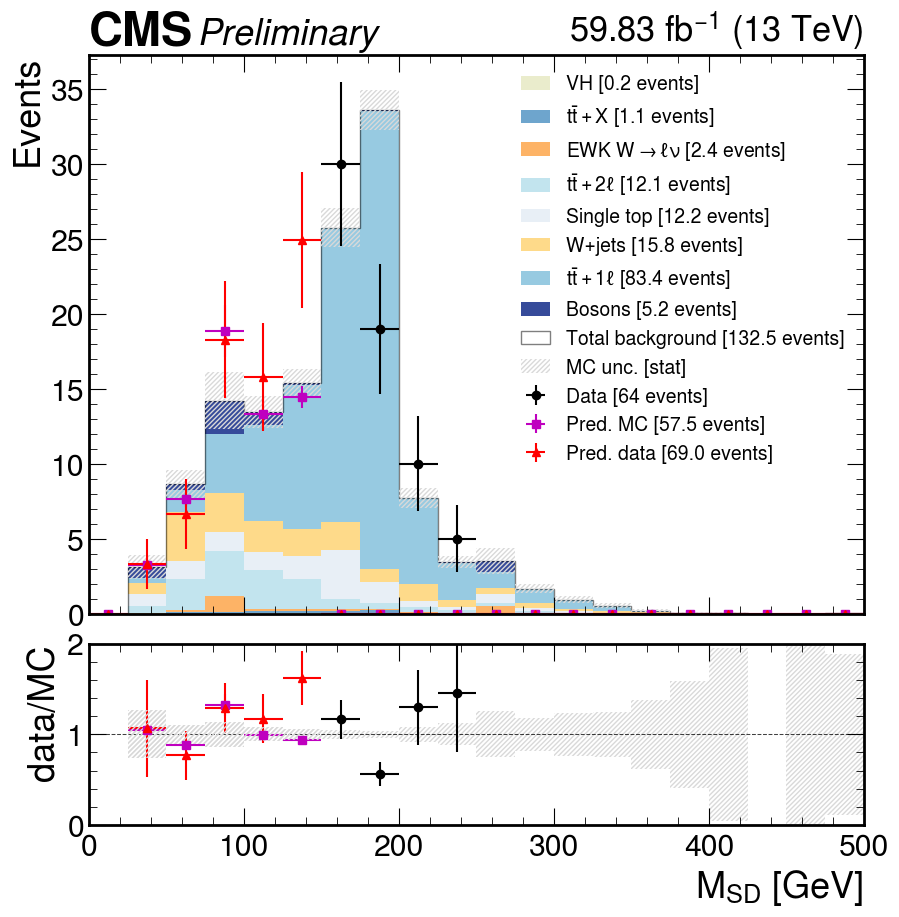

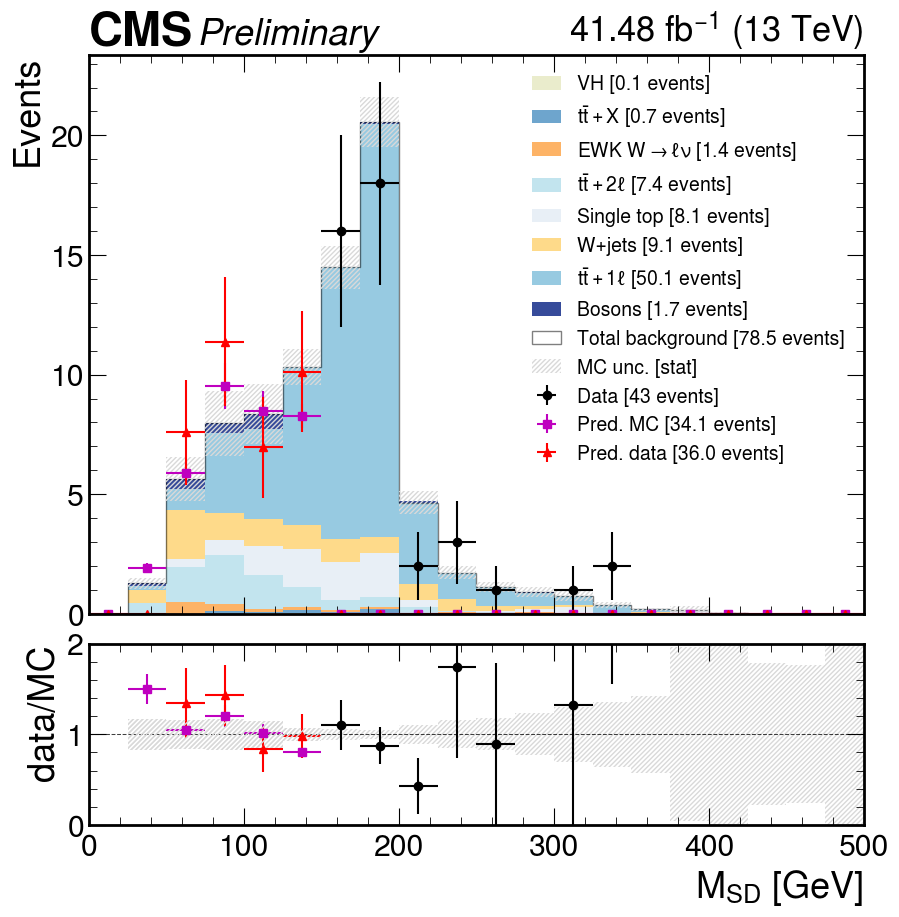

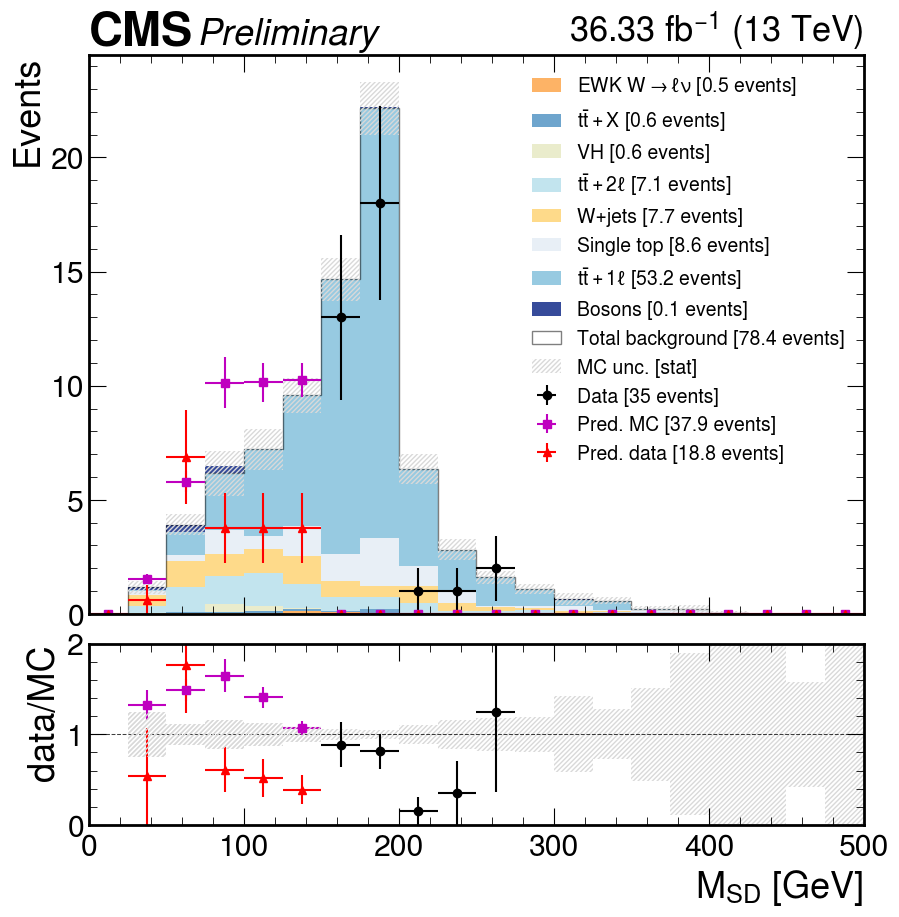

In [12]:
column = "hbbjet_msoftdrop"
bins = np.linspace(0, 500, 21)
x_label = r"$M_{SD}$ [GeV]"

for year in [2018, 2017, 2016]:

    # if year == -2016:
    #     return 19.52
    # elif year == 2016:
    #     return 16.81
    if year == 2016:
        vbswh.lumi = 36.33
    elif year == 2017:
        vbswh.lumi = 41.48
    elif year == 2018:
        vbswh.lumi = 59.83

    BtoA = vbswh.data_count(selection=f"(abs(year) == {year}) and regionA")/vbswh.data_count(selection=f"(abs(year) == {year}) and regionB")
    BtoA_MC = vbswh.bkg_count(selection=f"(abs(year) == {year}) and regionA")/vbswh.bkg_count(selection=f"(abs(year) == {year}) and regionB")
    
    regionD = "(presel_noDetaJJ and M_jj > 600 and ST > 900 and hbbjet_score > 0.9 and abs_deta_jj > 4 and hbbjet_msoftdrop < 150)"

    hist_axes, ratio_axes = vbswh.plot_data_vs_mc(
        column, 
        bins=bins, 
        selection=f"(abs(year) == {year}) and (regionA or {regionD})",
        x_label=x_label,
        stacked=True,
        blinded_range=(0, 150),
        blinded_box=False,
        autoblind=False
    )

    # Get numerator (data) and denominator (bkg MC)
    denom_df = vbswh.bkg_df(selection=f"(abs(year) == {year}) and {regionD}")
    denom = yahist.Hist1D(
        denom_df[column],
        bins=np.linspace(0, 500, 21),
        weights=denom_df.event_weight,
    );
    numer_df = vbswh.data_df(selection=f"(abs(year) == {year}) and regionC")
    numer = yahist.Hist1D(
        numer_df[column],
        bins=np.linspace(0, 500, 21),
        weights=numer_df.event_weight*BtoA,
        label=f"Pred. data [{len(numer_df)*BtoA:.1f} events]",
        color="r"
    );
    
    numerMC_df = vbswh.bkg_df(selection=f"(abs(year) == {year}) and regionC")
    numerMC = yahist.Hist1D(
        numerMC_df[column],
        bins=np.linspace(0, 500, 21),
        weights=numerMC_df.event_weight*BtoA_MC,
        label=f"Pred. MC [{np.sum(numerMC_df.event_weight)*BtoA_MC:.1f} events]",
        color="m"
    );

    # Get ratio
    ratio = numer/denom
    # Set ratio errors to data relative stat error times the ratio
    numer_counts = numer.counts
    numer_counts[numer_counts == 0] = 1e-12
    ratio._errors = (numer.errors/numer_counts)*ratio.counts
    
    # Get ratio
    ratioMC = numerMC/denom
    # Set ratio errors to data relative stat error times the ratio
    numerMC_counts = numerMC.counts
    numerMC_counts[numerMC_counts == 0] = 1e-12
    ratioMC._errors = (numerMC.errors/numerMC_counts)*ratioMC.counts

    # Plot hists and ratio
    numerMC.plot(ax=hist_axes, errors=True, fmt="s")
    ratioMC.plot(ax=ratio_axes, errors=True, fmt="s")
    numer.plot(ax=hist_axes, errors=True, fmt="^")
    ratio.plot(ax=ratio_axes, errors=True, fmt="^")

    # Plot MC relative stat error on unity; this makes no sense, but is LHC common practice
    denom_counts = denom.counts
    denom_counts[denom_counts == 0] = 1e-12
    err_points = np.repeat(denom.edges, 2)[1:-1]
    err_high = np.repeat(1 + denom.errors/denom_counts, 2)
    err_low = np.repeat(1 - denom.errors/denom_counts, 2)
    ratio_axes.fill_between(
        err_points, err_high, err_low,
        step="mid",
        hatch="///////",
        facecolor="none",
        edgecolor=(0.85, 0.85, 0.85),
        linewidth=0.0,
        linestyle="-",
        zorder=2
    )

    hist_axes.legend(fontsize=14)

    ratio_axes.set_ylim([0., 2.0])
    ratio_axes.legend().remove()

    vbswh.lumi = 138

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/main/val/hbbjet_msoftdrop_data_vs_mc_(abs(year)_eq_2018)_and_(regionB_or_regionC).pdf
Wrote plot to /home/users/jguiang/public_html/vbswh_plots/main/val/hbbjet_msoftdrop_data_vs_mc_(abs(year)_eq_2017)_and_(regionB_or_regionC).pdf
Wrote plot to /home/users/jguiang/public_html/vbswh_plots/main/val/hbbjet_msoftdrop_data_vs_mc_(abs(year)_eq_2016)_and_(regionB_or_regionC).pdf


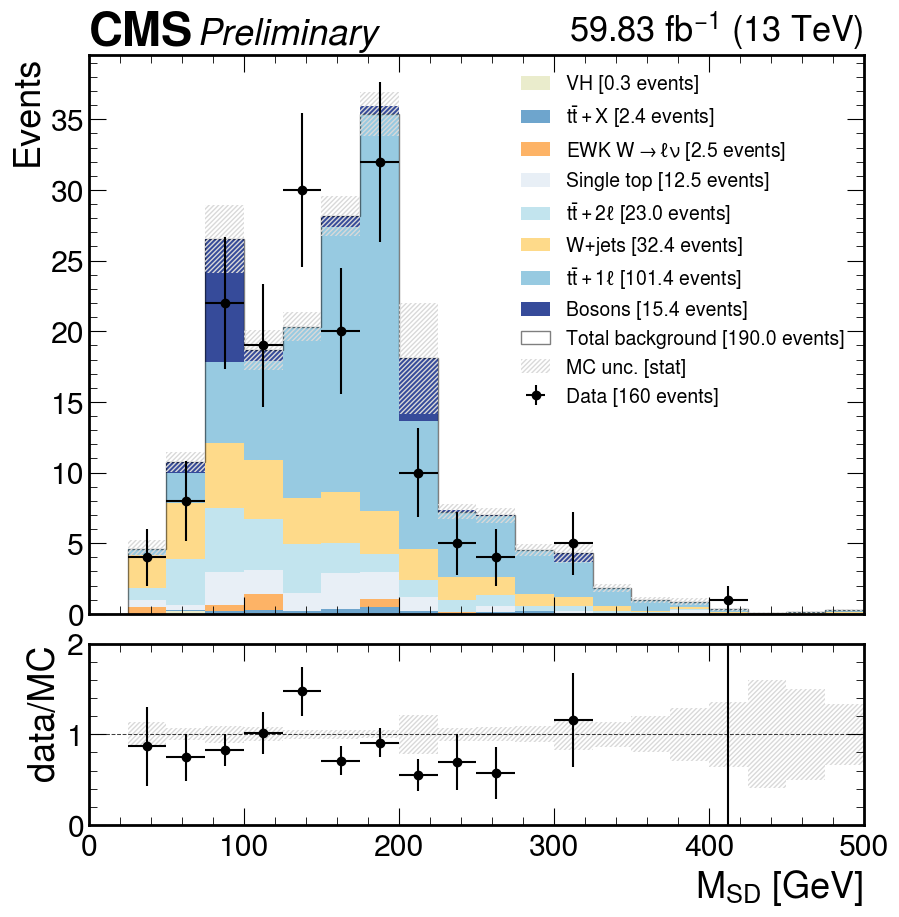

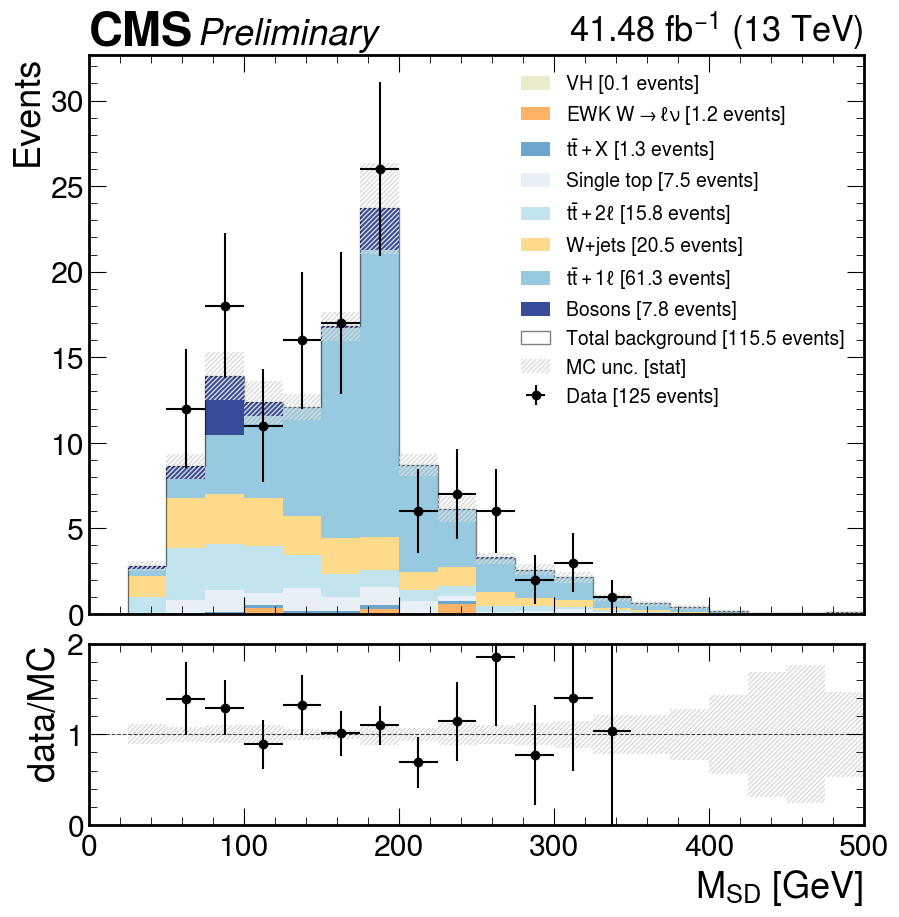

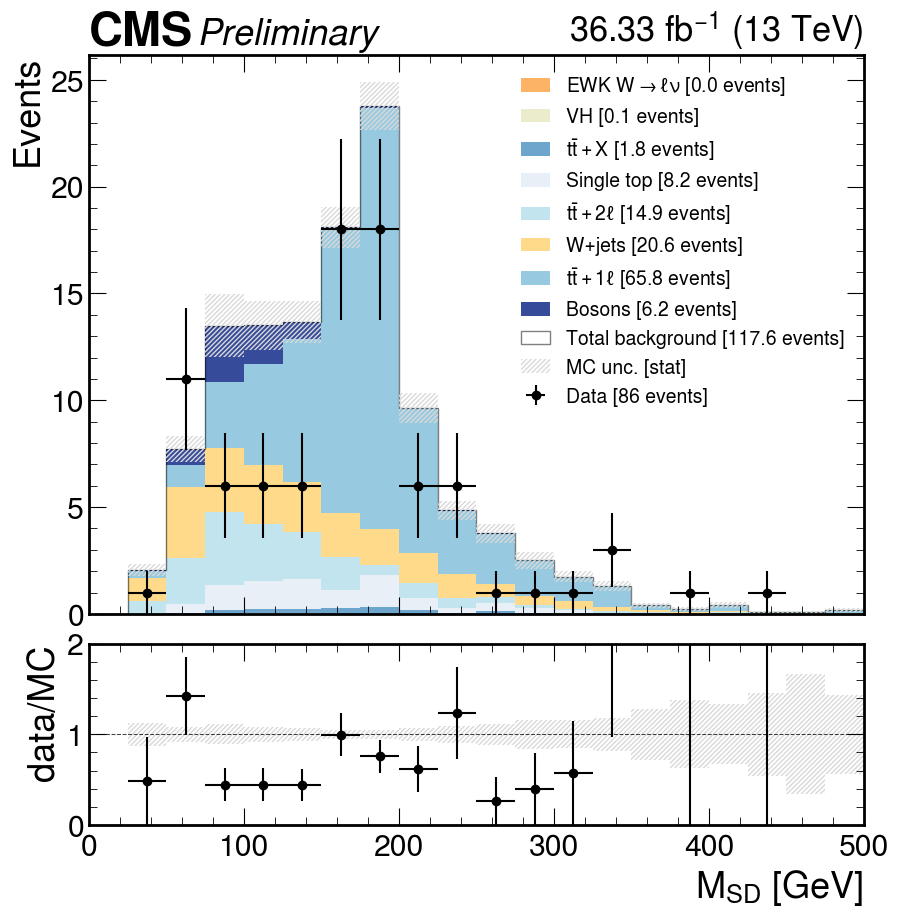

In [13]:
for year in [2018, 2017, 2016]:

    # if year == -2016:
    #     return 19.52
    # elif year == 2016:
    #     return 16.81
    if year == 2016:
        vbswh.lumi = 36.33
    elif year == 2017:
        vbswh.lumi = 41.48
    elif year == 2018:
        vbswh.lumi = 59.83

    hist_axes, ratio_axes = vbswh.plot_data_vs_mc(
        "hbbjet_msoftdrop", 
        bins=np.linspace(0, 500, 21), 
        selection=f"(abs(year) == {year}) and (regionB or regionC)",
    #     blinded_range=(1500, 1800) if selection == "regionC" or selection == "regionA" else None,
        x_label=r"$M_{SD}$ [GeV]",
    #     norm=True,
        stacked=True,
        autoblind=False
    )

    ratio_axes.set_ylim([0., 2.0])
    vbswh.lumi = 138

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/main/val/hbbjet_msoftdrop_data_vs_mc_(regionA_or_(presel_noDetaJJ_and_M_jj_gt_600_and_ST_gt_900_and_hbbjet_score_gt_0p9_and_abs_deta_jj_gt_4_and_hbbjet_msoftdrop_lt_150)).pdf


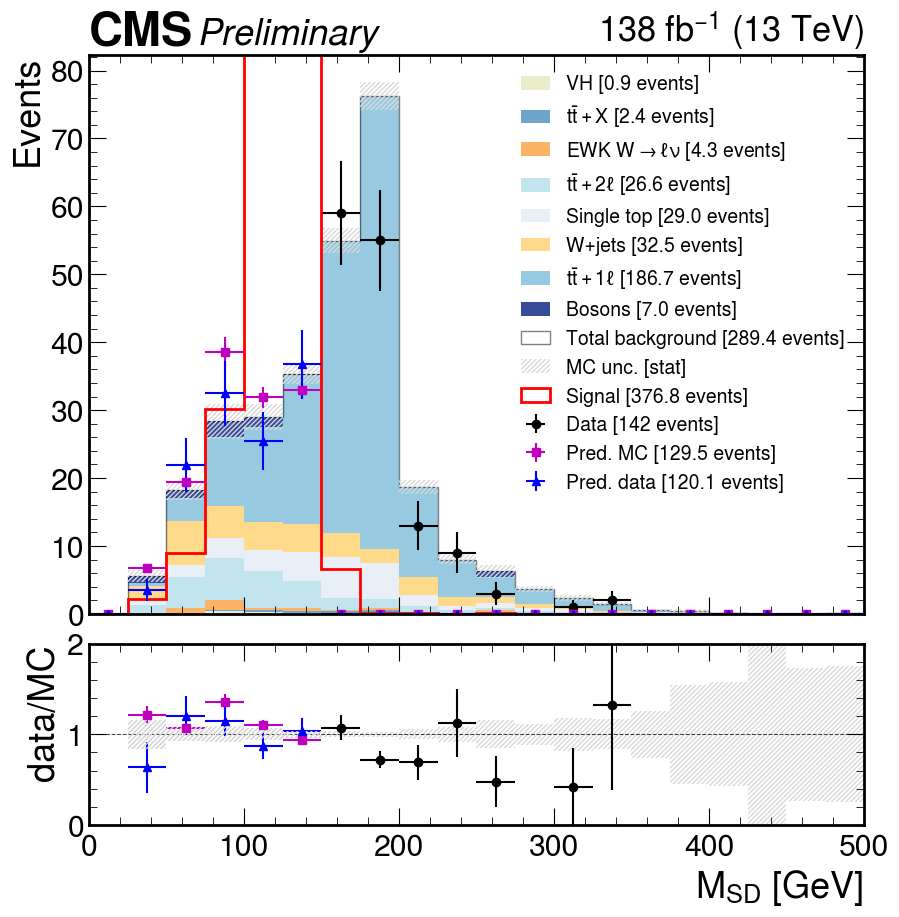

In [14]:
column = "hbbjet_msoftdrop"
bins = np.linspace(0, 500, 21)
x_label = r"$M_{SD}$ [GeV]"

BtoA = vbswh.data_count(selection="regionA")/vbswh.data_count(selection="regionB")
BtoA_mc = vbswh.bkg_count(selection="regionA")/vbswh.bkg_count(selection="regionB")

regionD = "(presel_noDetaJJ and M_jj > 600 and ST > 900 and hbbjet_score > 0.9 and abs_deta_jj > 4 and hbbjet_msoftdrop < 150)"

hist_axes, ratio_axes = vbswh.plot_data_vs_mc(
    column, 
    bins=bins, 
    selection=f"(regionA or {regionD})",
    x_label=x_label,
    stacked=True,
    blinded_range=(0, 150),
    blinded_box=False,
    autoblind=False
)

# Get numerator (data) and denominator (bkg MC)
denom_df = vbswh.bkg_df(selection=f"{regionD}")
denom = yahist.Hist1D(
    denom_df[column],
    bins=np.linspace(0, 500, 21),
    weights=denom_df.event_weight,
);
numer_df = vbswh.data_df(selection="regionC")
numer = yahist.Hist1D(
    numer_df[column],
    bins=np.linspace(0, 500, 21),
    weights=numer_df.event_weight*BtoA,
    label=f"Pred. data [{len(numer_df)*BtoA:.1f} events]",
    color="b"
);
numer_mc_df = vbswh.bkg_df(selection="regionC")
numer_mc = yahist.Hist1D(
    numer_mc_df[column],
    bins=np.linspace(0, 500, 21),
    weights=numer_mc_df.event_weight*BtoA_mc,
    label=f"Pred. MC [{np.sum(numer_mc_df.event_weight)*BtoA_mc:.1f} events]",
    color="m"
);
sig_df = vbswh.sig_df(selection="presel_noDetaJJ and M_jj > 600 and ST > 900 and hbbjet_score > 0.9")
sig = yahist.Hist1D(
    sig_df[column],
    bins=np.linspace(0, 500, 21),
    weights=sig_df.event_weight,
    label=f"Signal [{np.sum(sig_df.event_weight):.1f} events]",
    color="r"
);
    
# Get ratio
ratio = numer/denom
# Set ratio errors to data relative stat error times the ratio
numer_counts = numer.counts
numer_counts[numer_counts == 0] = 1e-12
ratio._errors = (numer.errors/numer_counts)*ratio.counts

# Get ratio
ratio_mc = numer_mc/denom
# Set ratio errors to data relative stat error times the ratio
numer_mc_counts = numer_mc.counts
numer_mc_counts[numer_mc_counts == 0] = 1e-12
ratio_mc._errors = (numer_mc.errors/numer_mc_counts)*ratio_mc.counts

# Plot hists and ratio
sig.plot(ax=hist_axes, linewidth=2)
numer_mc.plot(ax=hist_axes, errors=True, fmt="s")
ratio_mc.plot(ax=ratio_axes, errors=True, fmt="s")
numer.plot(ax=hist_axes, errors=True, fmt="^")
ratio.plot(ax=ratio_axes, errors=True, fmt="^")

# Plot MC relative stat error on unity; this makes no sense, but is LHC common practice
denom_counts = denom.counts
denom_counts[denom_counts == 0] = 1e-12
err_points = np.repeat(denom.edges, 2)[1:-1]
err_high = np.repeat(1 + denom.errors/denom_counts, 2)
err_low = np.repeat(1 - denom.errors/denom_counts, 2)
ratio_axes.fill_between(
    err_points, err_high, err_low,
    step="mid",
    hatch="///////",
    facecolor="none",
    edgecolor=(0.85, 0.85, 0.85),
    linewidth=0.0,
    linestyle="-",
    zorder=2
)

hist_axes.legend(fontsize=14)

ratio_axes.set_ylim([0., 2.0])
ratio_axes.legend().remove()

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/main/val/hbbjet_msoftdrop_data_vs_mc_(regionB_or_regionC).pdf


(0.0, 2.0)

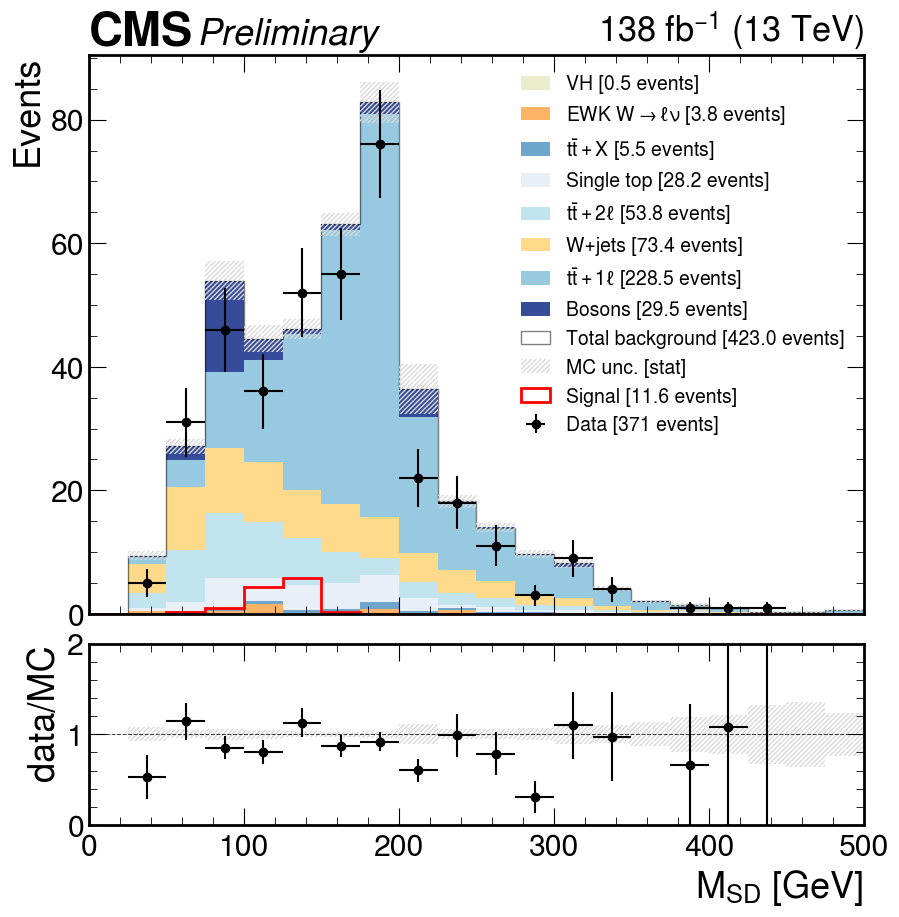

In [15]:
hist_axes, ratio_axes = vbswh.plot_data_vs_mc(
    "hbbjet_msoftdrop", 
    bins=np.linspace(0, 500, 21), 
    selection="(regionB or regionC)",
#     blinded_range=(1500, 1800) if selection == "regionC" or selection == "regionA" else None,
    x_label=r"$M_{SD}$ [GeV]",
#     norm=True,
    stacked=True,
    autoblind=False
)

sig_df = vbswh.sig_df(selection="(regionB or regionC)")
sig = yahist.Hist1D(
    sig_df[column],
    bins=np.linspace(0, 500, 21),
    weights=sig_df.event_weight,
    label=f"Signal [{np.sum(sig_df.event_weight):.1f} events]",
    color="r"
);
sig.plot(ax=hist_axes, linewidth=2)
hist_axes.legend(fontsize=14)

ratio_axes.set_ylim([0., 2.0])

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/main/val/hbbjet_msoftdrop_data_vs_mc_(regionA_or_(presel_noDetaJJ_and_M_jj_gt_600_and_ST_gt_900_and_hbbjet_score_gt_0p9_and_abs_deta_jj_gt_4_and_hbbjet_msoftdrop_lt_150)).pdf


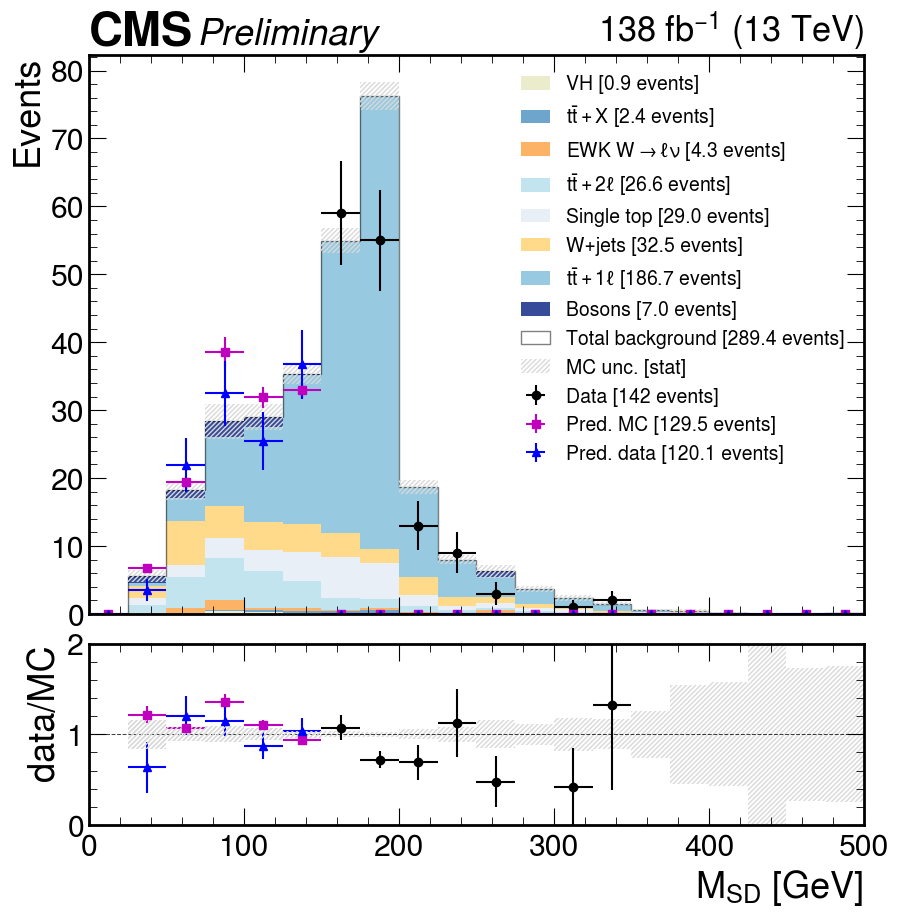

In [16]:
column = "hbbjet_msoftdrop"
bins = np.linspace(0, 500, 21)
x_label = r"$M_{SD}$ [GeV]"

BtoA = vbswh.data_count(selection="regionA")/vbswh.data_count(selection="regionB")
BtoA_mc = vbswh.bkg_count(selection="regionA")/vbswh.bkg_count(selection="regionB")

regionD = "(presel_noDetaJJ and M_jj > 600 and ST > 900 and hbbjet_score > 0.9 and abs_deta_jj > 4 and hbbjet_msoftdrop < 150)"

hist_axes, ratio_axes = vbswh.plot_data_vs_mc(
    column, 
    bins=bins, 
    selection=f"(regionA or {regionD})",
    x_label=x_label,
    stacked=True,
    blinded_range=(0, 150),
    blinded_box=False,
    autoblind=False
)

# Get numerator (data) and denominator (bkg MC)
denom_df = vbswh.bkg_df(selection=f"{regionD}")
denom = yahist.Hist1D(
    denom_df[column],
    bins=np.linspace(0, 500, 21),
    weights=denom_df.event_weight,
);
numer_df = vbswh.data_df(selection="regionC")
numer = yahist.Hist1D(
    numer_df[column],
    bins=np.linspace(0, 500, 21),
    weights=numer_df.event_weight*BtoA,
    label=f"Pred. data [{len(numer_df)*BtoA:.1f} events]",
    color="b"
);
numer_mc_df = vbswh.bkg_df(selection="regionC")
numer_mc = yahist.Hist1D(
    numer_mc_df[column],
    bins=np.linspace(0, 500, 21),
    weights=numer_mc_df.event_weight*BtoA_mc,
    label=f"Pred. MC [{np.sum(numer_mc_df.event_weight)*BtoA_mc:.1f} events]",
    color="m"
);
    
# Get ratio
ratio = numer/denom
# Set ratio errors to data relative stat error times the ratio
numer_counts = numer.counts
numer_counts[numer_counts == 0] = 1e-12
ratio._errors = (numer.errors/numer_counts)*ratio.counts

# Get ratio
ratio_mc = numer_mc/denom
# Set ratio errors to data relative stat error times the ratio
numer_mc_counts = numer_mc.counts
numer_mc_counts[numer_mc_counts == 0] = 1e-12
ratio_mc._errors = (numer_mc.errors/numer_mc_counts)*ratio_mc.counts

# Plot hists and ratio
numer_mc.plot(ax=hist_axes, errors=True, fmt="s")
ratio_mc.plot(ax=ratio_axes, errors=True, fmt="s")
numer.plot(ax=hist_axes, errors=True, fmt="^")
ratio.plot(ax=ratio_axes, errors=True, fmt="^")

# Plot MC relative stat error on unity; this makes no sense, but is LHC common practice
denom_counts = denom.counts
denom_counts[denom_counts == 0] = 1e-12
err_points = np.repeat(denom.edges, 2)[1:-1]
err_high = np.repeat(1 + denom.errors/denom_counts, 2)
err_low = np.repeat(1 - denom.errors/denom_counts, 2)
ratio_axes.fill_between(
    err_points, err_high, err_low,
    step="mid",
    hatch="///////",
    facecolor="none",
    edgecolor=(0.85, 0.85, 0.85),
    linewidth=0.0,
    linestyle="-",
    zorder=2
)

hist_axes.legend(fontsize=14)

ratio_axes.set_ylim([0., 2.0])
ratio_axes.legend().remove()

plt.savefig(f"{PLOTSDIR}/regionsAD_closure.pdf")

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/main/val/hbbjet_msoftdrop_data_vs_mc_(regionB_or_regionC).pdf


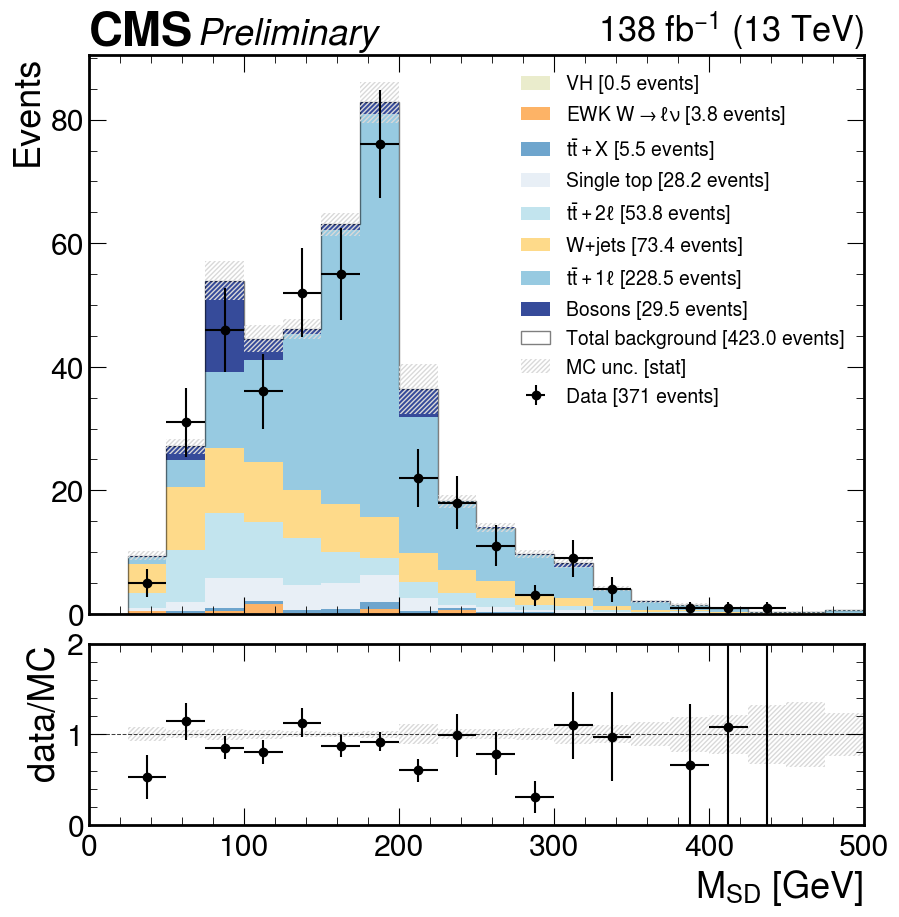

In [17]:
hist_axes, ratio_axes = vbswh.plot_data_vs_mc(
    "hbbjet_msoftdrop", 
    bins=np.linspace(0, 500, 21), 
    selection="(regionB or regionC)",
#     blinded_range=(1500, 1800) if selection == "regionC" or selection == "regionA" else None,
    x_label=r"$M_{SD}$ [GeV]",
#     norm=True,
    stacked=True,
    autoblind=False
)

ratio_axes.set_ylim([0., 2.0])
plt.savefig(f"{PLOTSDIR}/regionsBC_closure.pdf")

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/main/val/hbbjet_score_data_vs_mc_presel_noDetaJJ_and_abs_deta_jj_leq_3.pdf


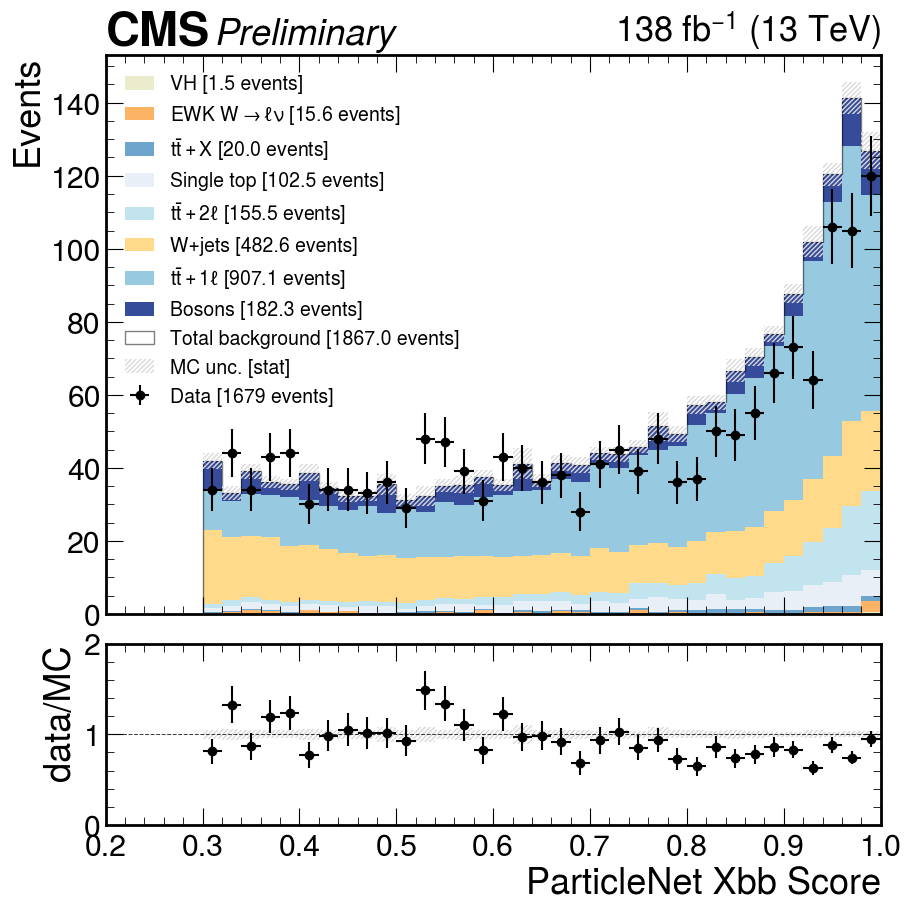

In [18]:
axes, _ = vbswh.plot_data_vs_mc(
    "hbbjet_score", np.linspace(0.2, 1, 41), 
    selection="presel_noDetaJJ and abs_deta_jj <= 3",
    x_label="ParticleNet Xbb Score",
    stacked=True, autoblind=False
);

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/main/val/hbbjet_msoftdrop_data_vs_mc_presel_noDetaJJ_and_abs_deta_jj_leq_3.pdf


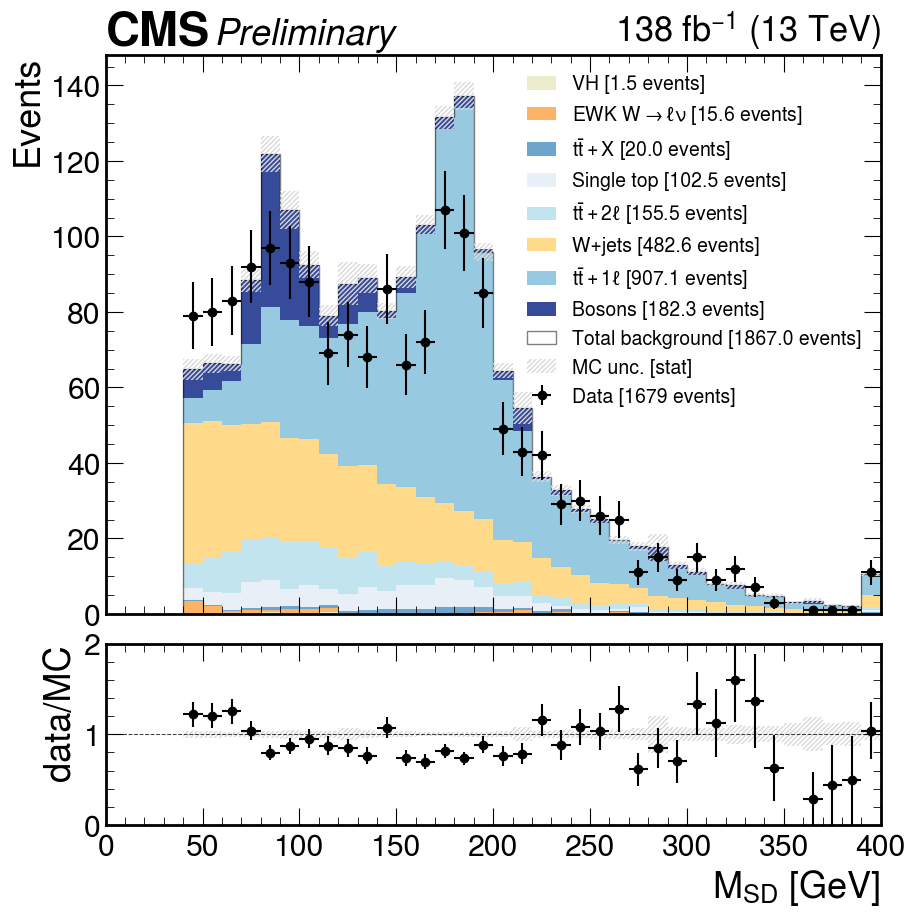

In [19]:
axes, _ = vbswh.plot_data_vs_mc(
    "hbbjet_msoftdrop", np.linspace(0, 400, 41), 
    selection="presel_noDetaJJ and abs_deta_jj <= 3",
    x_label="$M_{SD}$ [GeV]",
    stacked=True, autoblind=False,
#     norm=True
);
axes.set_ylim(ymin=0);

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/main/val/M_jj_data_vs_mc_regionB_and_ST_gt_1500.pdf


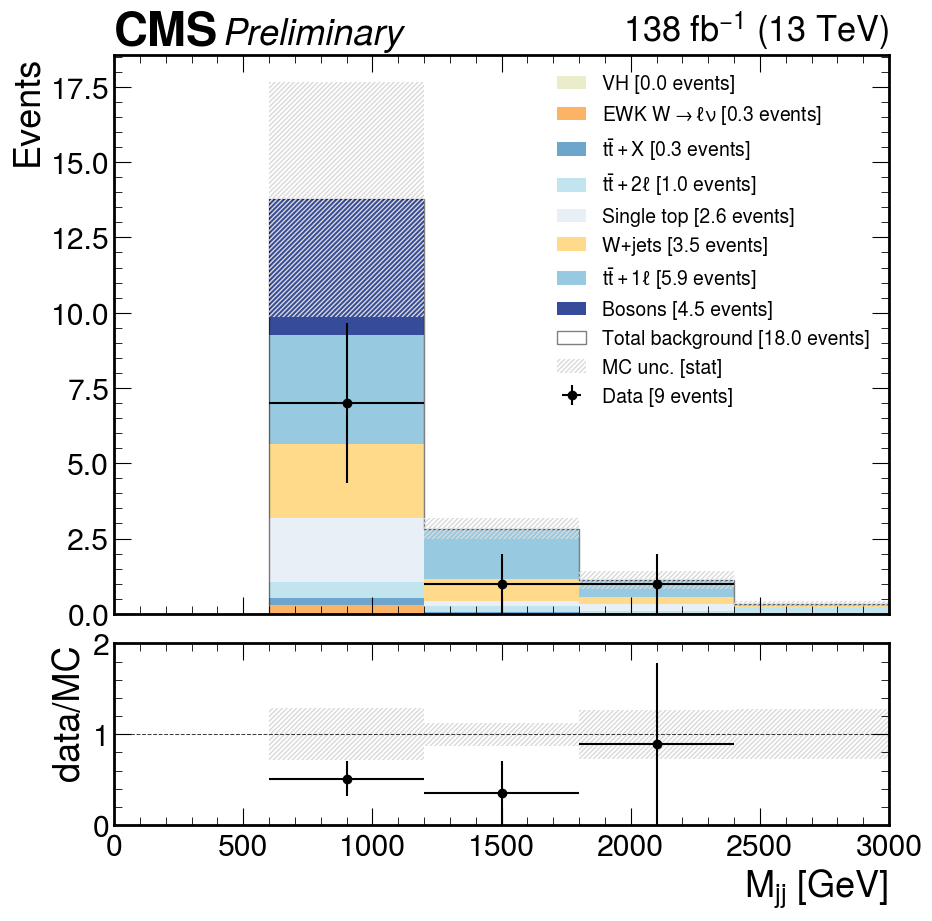

In [20]:
hist_axes, ratio_axes = vbswh.plot_data_vs_mc(
    "M_jj", bins=np.linspace(0, 3000, 6), 
    selection="regionB and ST > 1500",
    x_label=r"$M_{jj}$ [GeV]",
#     norm=True,
    stacked=True, autoblind=False
)

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/main/val/ST_data_vs_mc_regionA.pdf
Wrote plot to /home/users/jguiang/public_html/vbswh_plots/main/val/ST_data_vs_mc_regionB.pdf
Wrote plot to /home/users/jguiang/public_html/vbswh_plots/main/val/ST_data_vs_mc_regionC.pdf


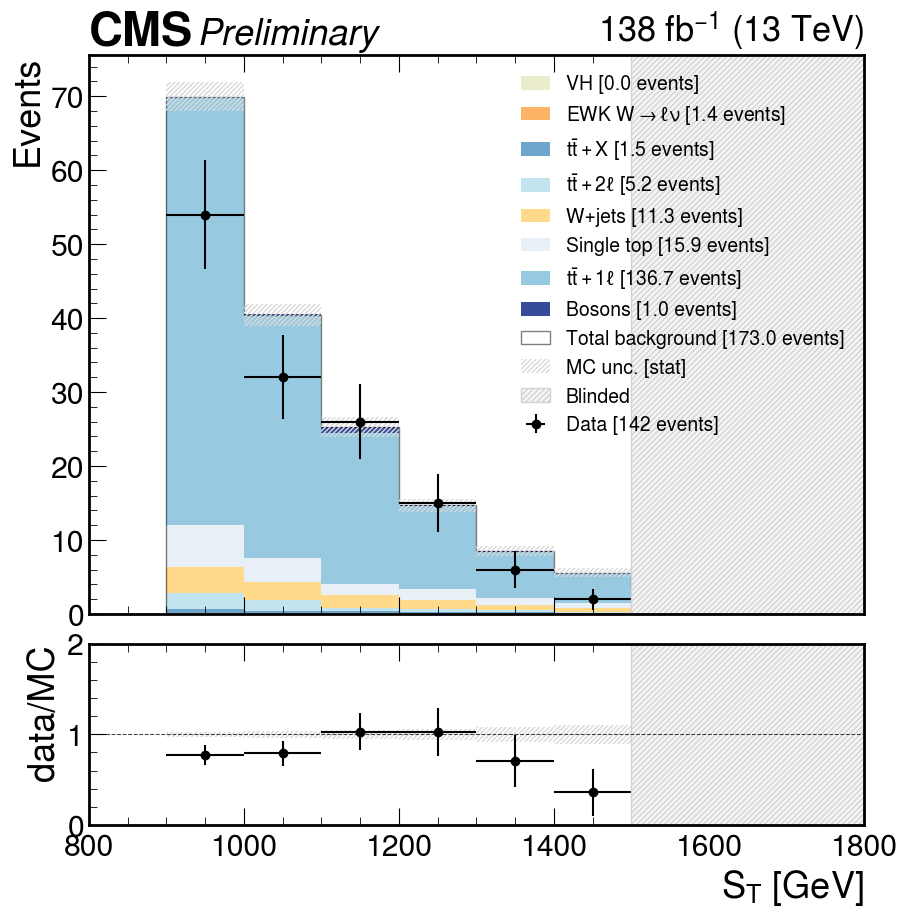

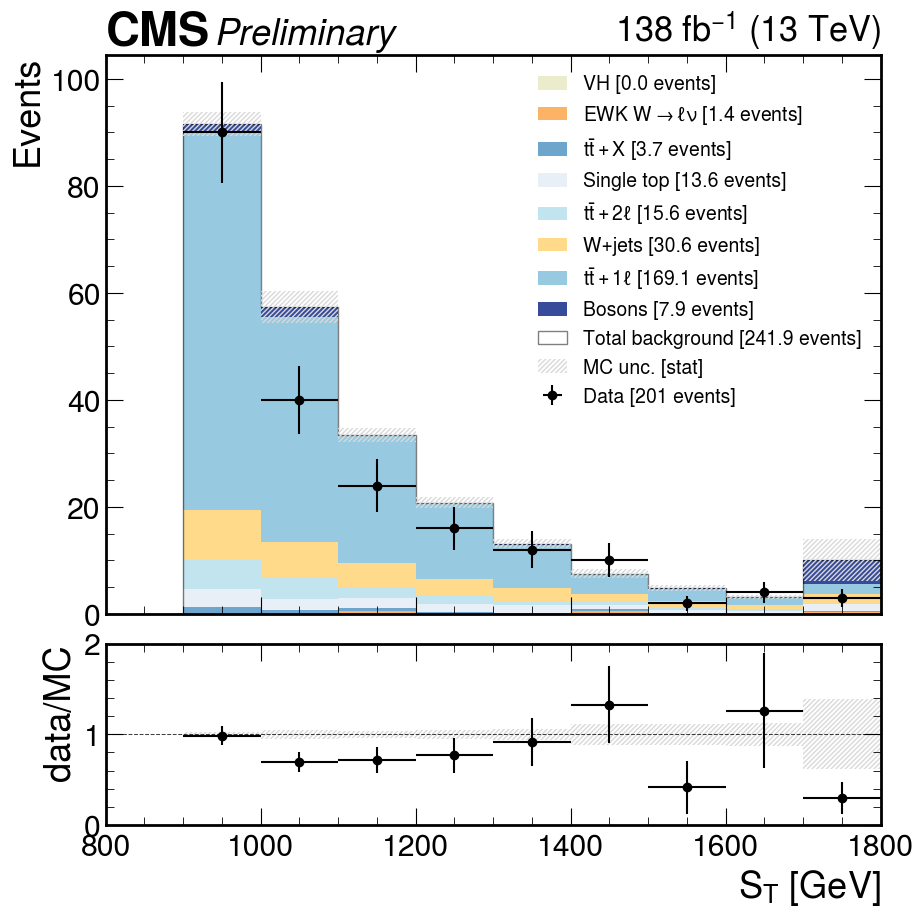

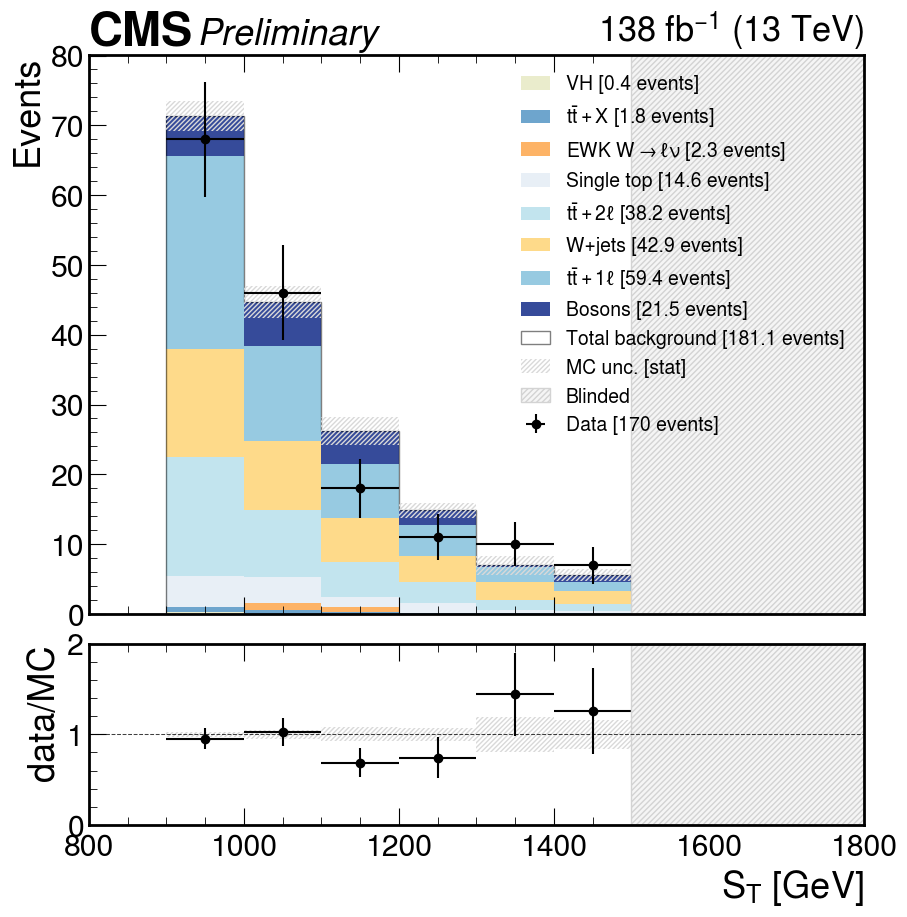

In [21]:
for selection in ["regionA", "regionB", "regionC"]:
    hist_axes, ratio_axes = vbswh.plot_data_vs_mc(
        "ST", 
        bins=np.linspace(800, 1800, 11), 
        selection=f"{selection}",
        blinded_range=(1500, 1800) if selection == "regionC" or selection == "regionA" else None,
        x_label=r"$S_T$ [GeV]",
        stacked=True,
        legend_loc="upper right", autoblind=False
    )

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/main/val/M_jj_data_vs_mc_regionA.pdf
Wrote plot to /home/users/jguiang/public_html/vbswh_plots/main/val/M_jj_data_vs_mc_regionB.pdf
Wrote plot to /home/users/jguiang/public_html/vbswh_plots/main/val/M_jj_data_vs_mc_regionC.pdf


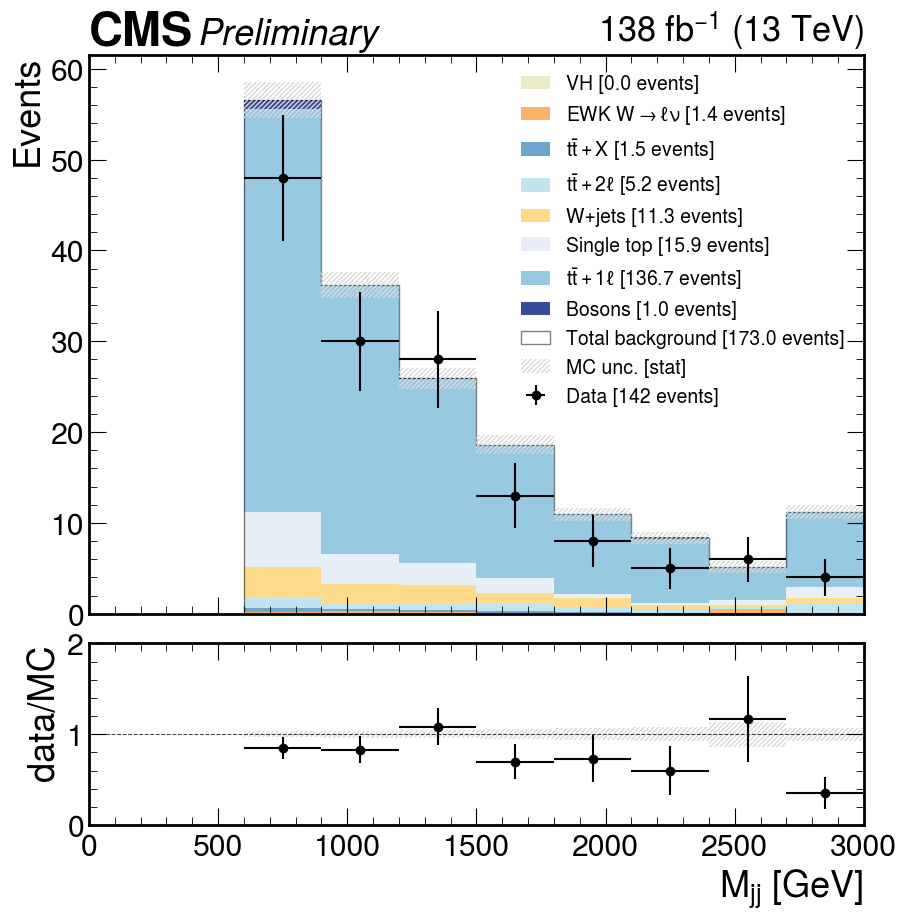

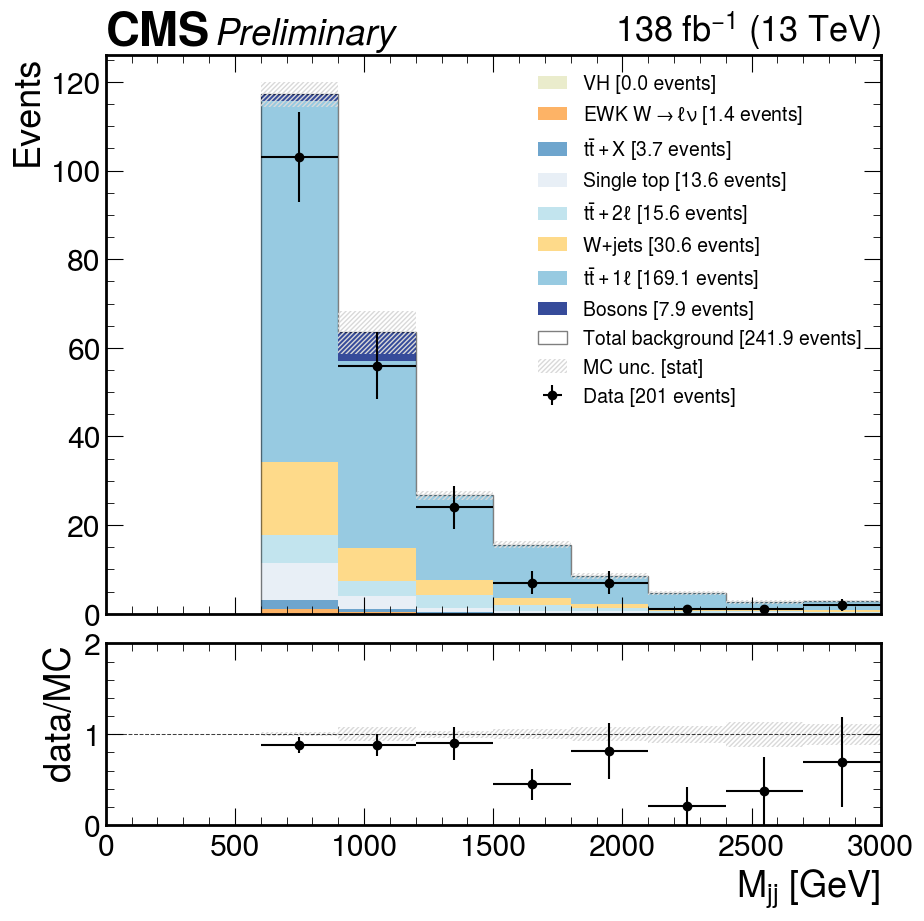

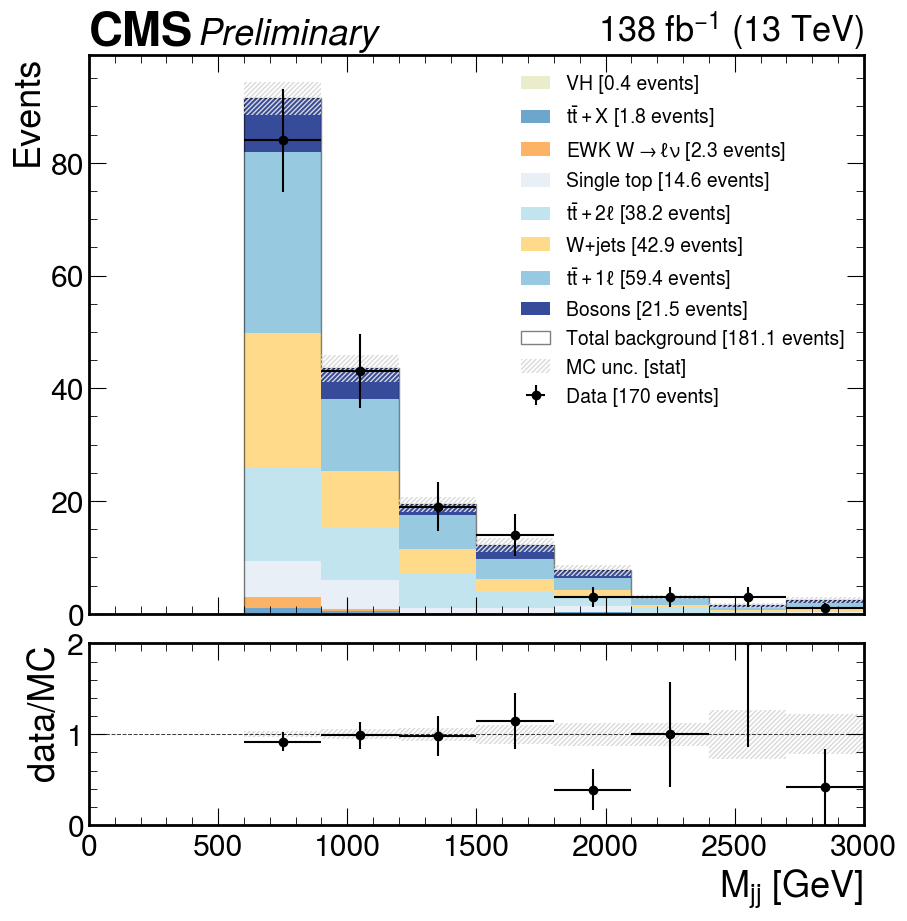

In [22]:
for selection in ["regionA", "regionB", "regionC"]:
    axes, _ = vbswh.plot_data_vs_mc(
        "M_jj", bins=np.linspace(0, 3000, 11), 
        selection=selection,
        x_label=r"$M_{jj}$ [GeV]",
    #     norm=True,
        stacked=True, autoblind=False
    )

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/main/val/deta_jj_data_vs_mc_regionA.pdf
Wrote plot to /home/users/jguiang/public_html/vbswh_plots/main/val/deta_jj_data_vs_mc_regionB.pdf
Wrote plot to /home/users/jguiang/public_html/vbswh_plots/main/val/deta_jj_data_vs_mc_regionC.pdf


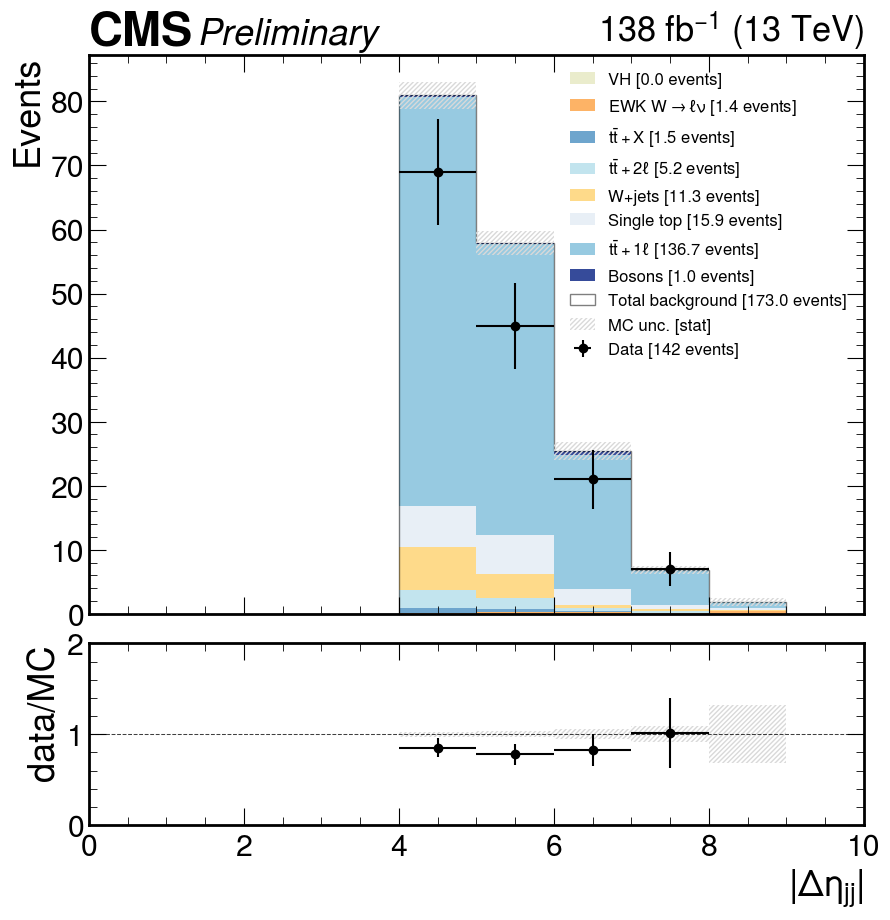

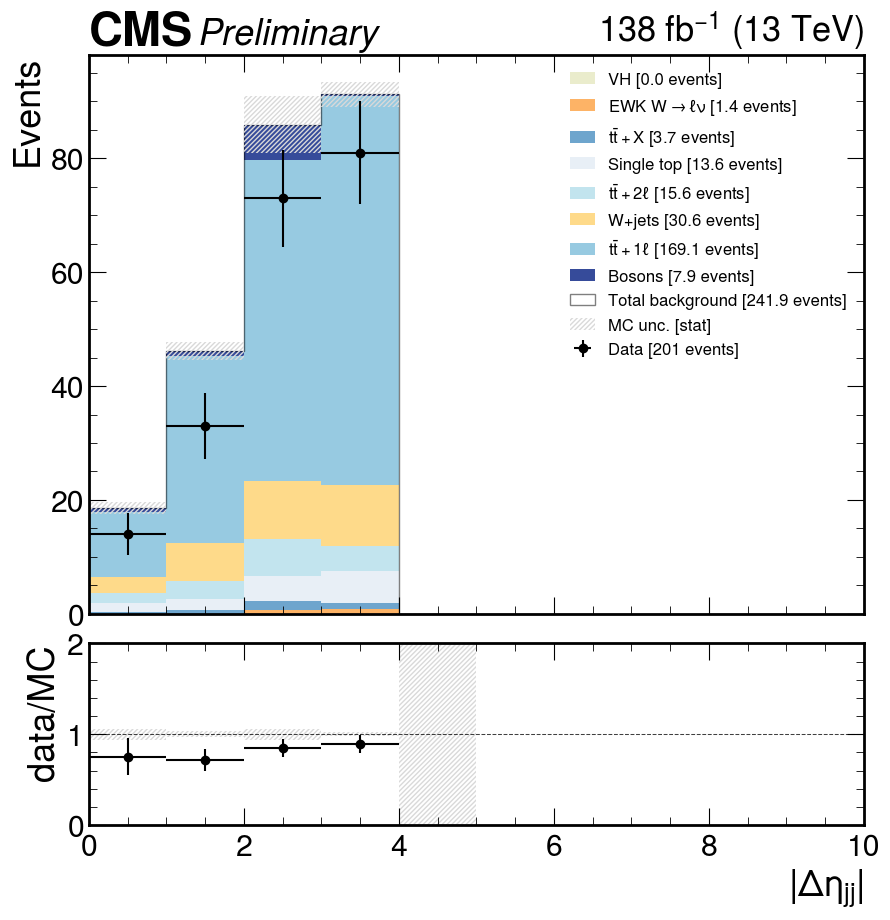

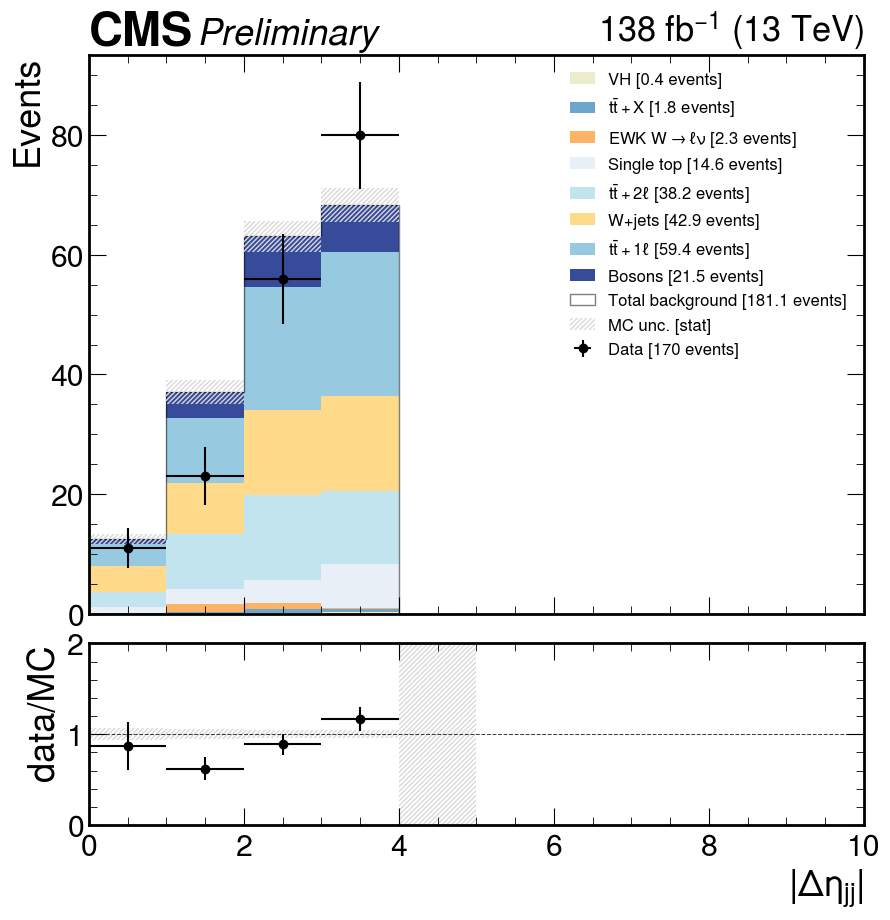

In [23]:
for selection in ["regionA", "regionB", "regionC"]:
    axes, _ = vbswh.plot_data_vs_mc(
        "deta_jj", bins=np.linspace(0,10,11), 
        selection=selection,
        transf=abs,
        x_label=r"$|\Delta\eta_{jj}|$",
    #     norm=True,
        stacked=True, autoblind=False
    )
    axes.legend(fontsize=12)

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/main/val/n_fatjets_data_vs_mc_regionA.pdf
Wrote plot to /home/users/jguiang/public_html/vbswh_plots/main/val/n_fatjets_data_vs_mc_regionB.pdf
Wrote plot to /home/users/jguiang/public_html/vbswh_plots/main/val/n_fatjets_data_vs_mc_regionC.pdf


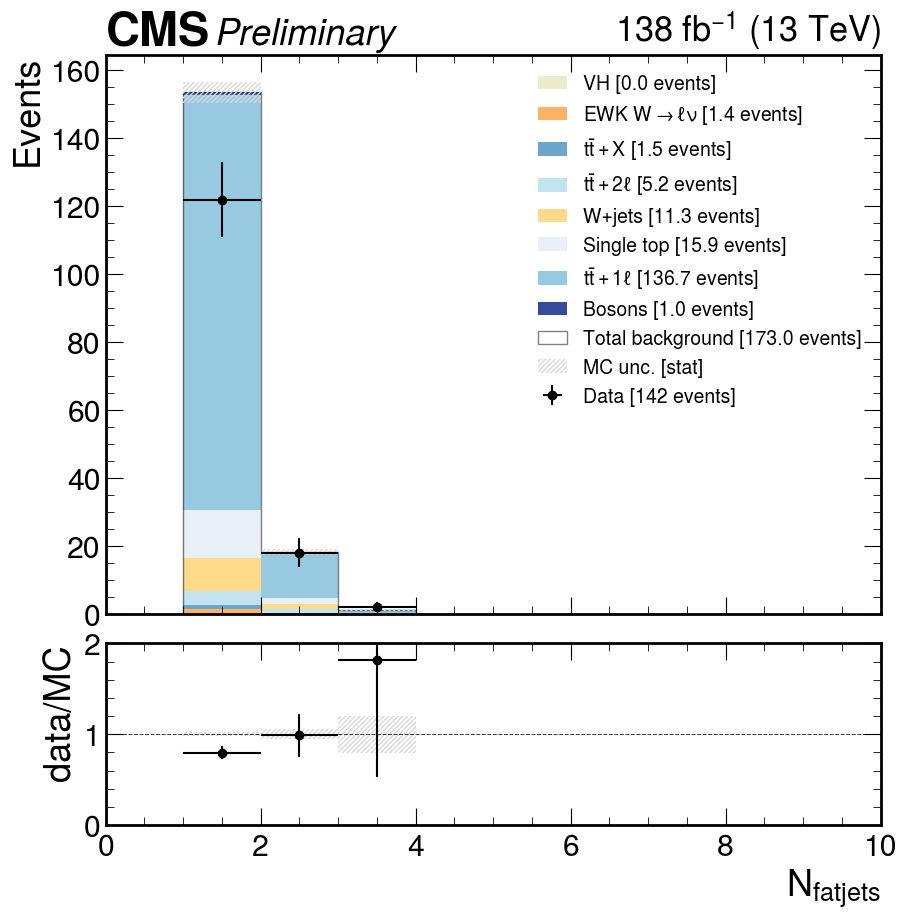

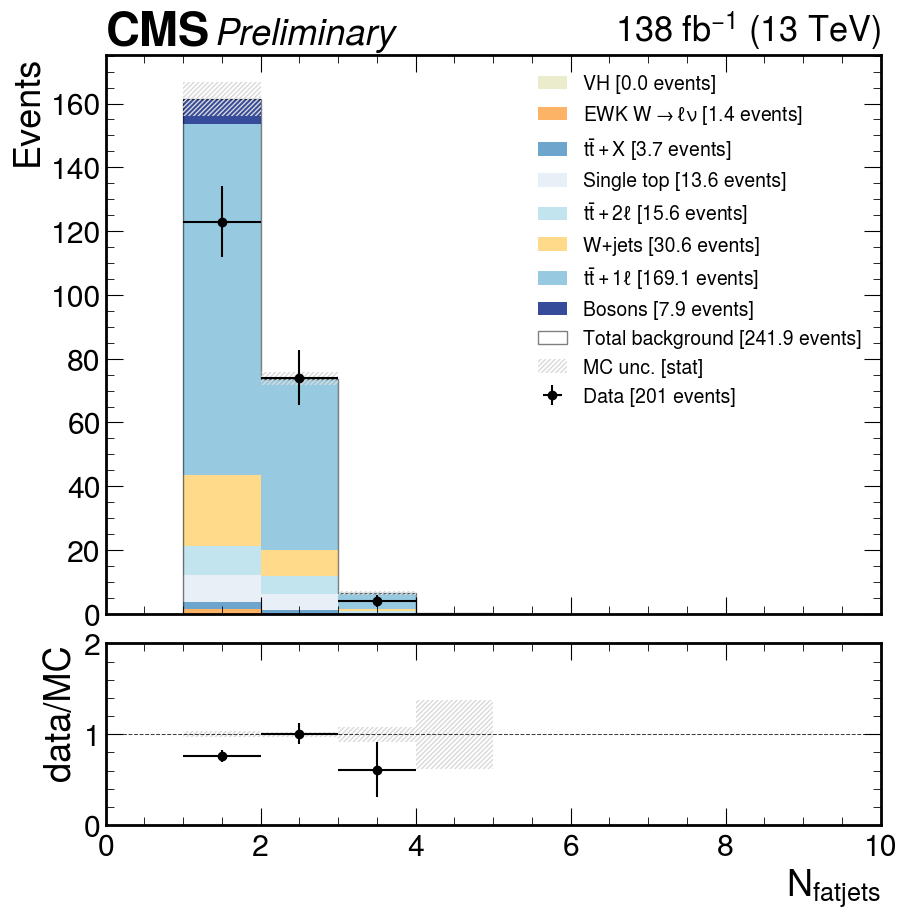

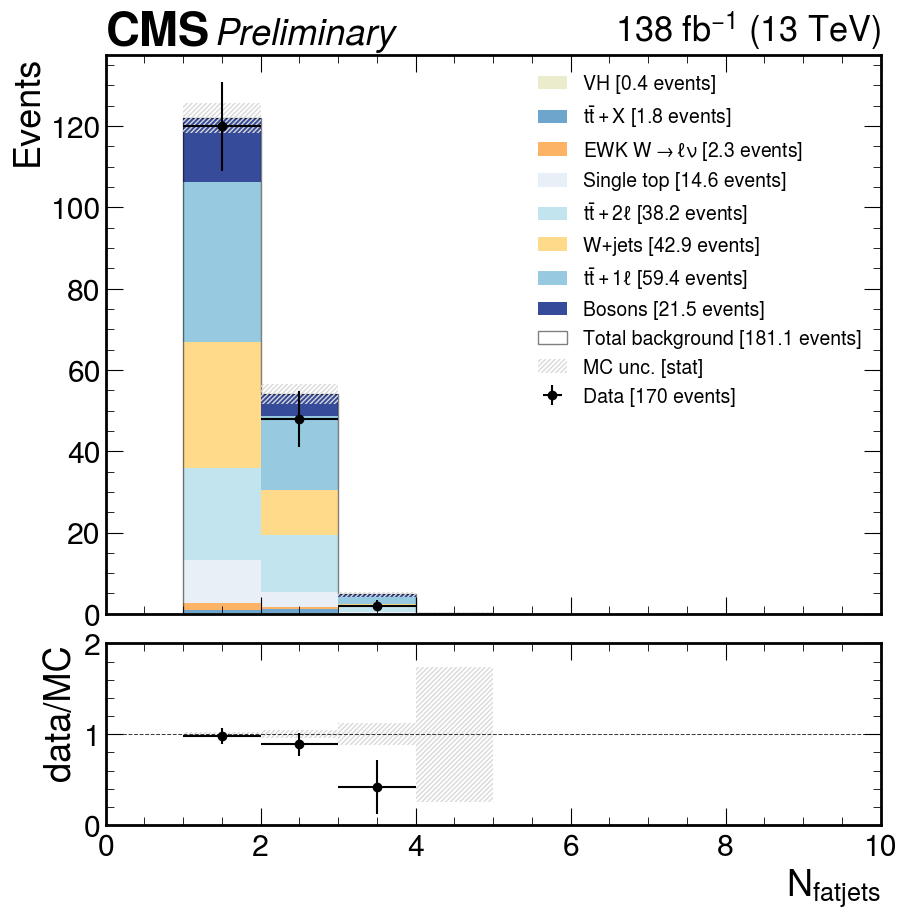

In [24]:
for selection in ["regionA", "regionB", "regionC"]:
    axes, _ = vbswh.plot_data_vs_mc(
        "n_fatjets", bins=np.linspace(0, 10, 11), 
        selection=selection,
        x_label=r"$N_{fatjets}$",
    #     norm=True,
        stacked=True, autoblind=False
    )

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/main/val/M_jj_data_vs_mc_presel_and_hbbjet_msoftdrop_geq_150.pdf


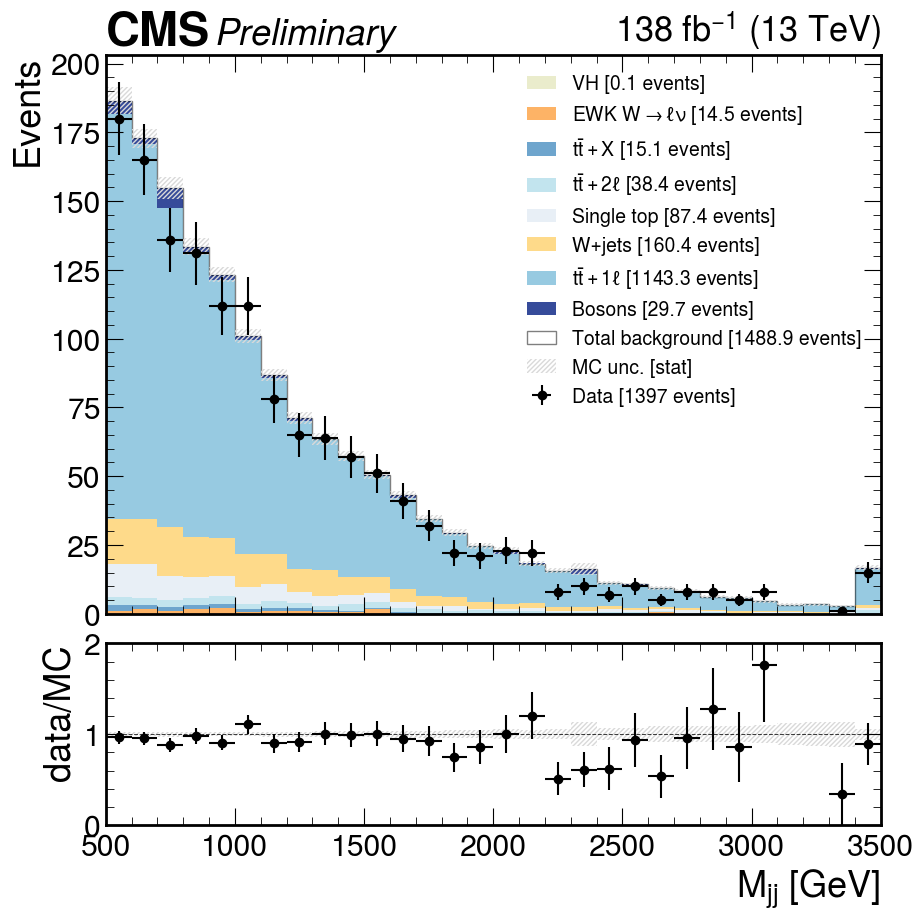

In [25]:
axes, _ = vbswh.plot_data_vs_mc(
    "M_jj", bins=np.linspace(500, 3500, 31), 
    selection="presel and hbbjet_msoftdrop >= 150",
    x_label=r"$M_{jj}$ [GeV]",
#     norm=True,
    stacked=True, autoblind=False
)

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/main/val/M_jj_data_vs_mc_presel_noDetaJJ_and_abs_deta_jj_leq_3.pdf


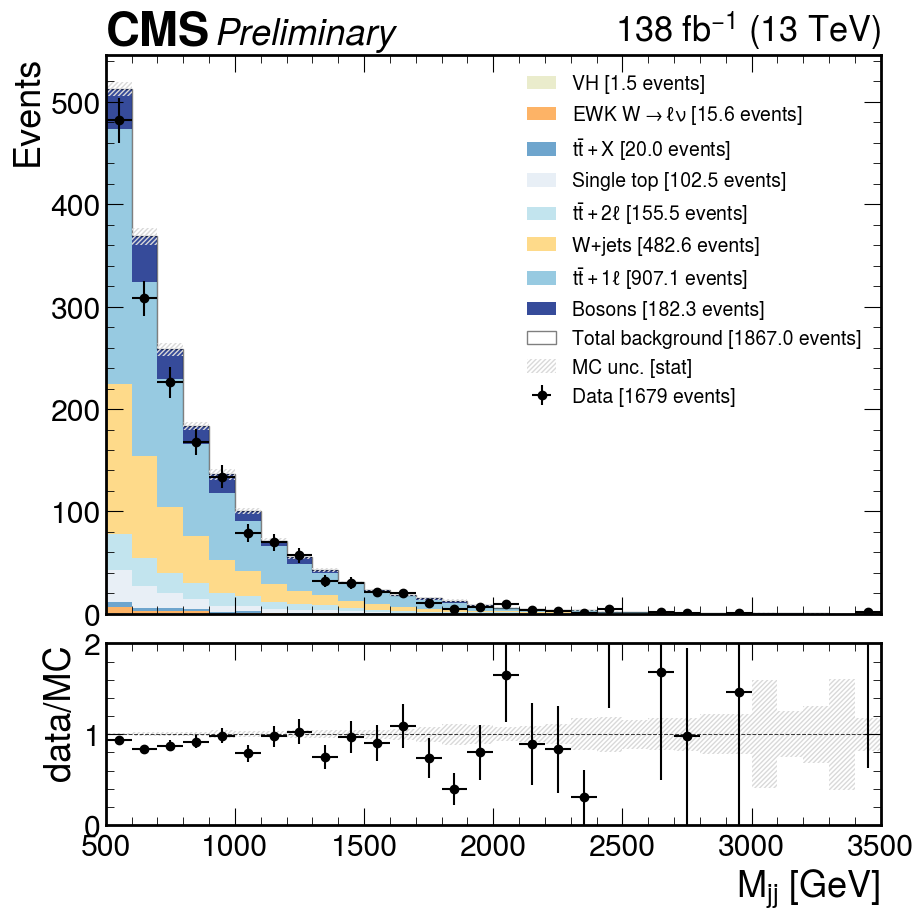

In [26]:
axes, _ = vbswh.plot_data_vs_mc(
    "M_jj", bins=np.linspace(500, 3500, 31), 
    selection="presel_noDetaJJ and abs_deta_jj <= 3",
    x_label=r"$M_{jj}$ [GeV]",
#     norm=True,
    stacked=True, autoblind=False
)

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/main/val/deta_jj_data_vs_mc_presel_noDetaJJ_and_abs_deta_jj_leq_3.pdf


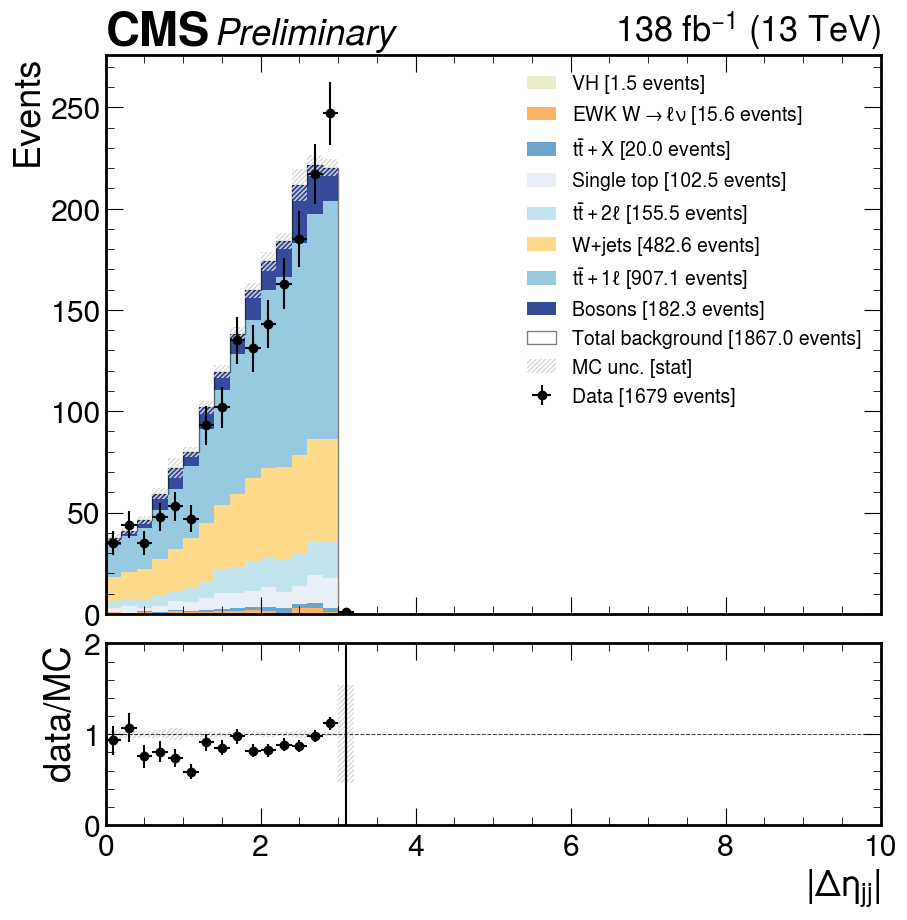

In [27]:
axes, _ = vbswh.plot_data_vs_mc(
    "deta_jj", bins=np.linspace(0, 10, 51), 
    selection="presel_noDetaJJ and abs_deta_jj <= 3",
    transf=abs,
    x_label=r"$|\Delta\eta_{jj}|$",
#     norm=True,
    stacked=True, autoblind=False
)

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/main/val/deta_jj_data_vs_mc_presel_and_hbbjet_msoftdrop_geq_150.pdf


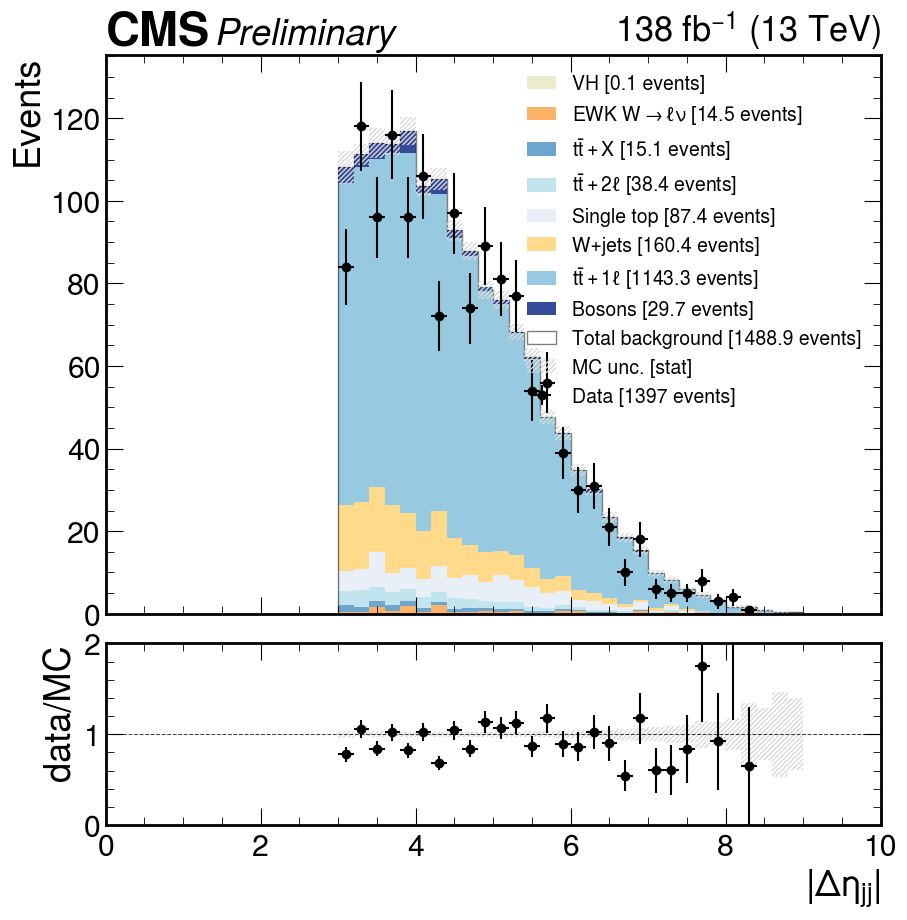

In [40]:
axes, _ = vbswh.plot_data_vs_mc(
    "deta_jj", bins=np.linspace(0,10,51), 
    selection="presel and hbbjet_msoftdrop >= 150",
    transf=abs,
    x_label=r"$|\Delta\eta_{jj}|$",
#     norm=True,
    stacked=True, autoblind=False
)

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/main/val/hbbjet_score_data_vs_mc_presel_and_hbbjet_msoftdrop_geq_150.pdf


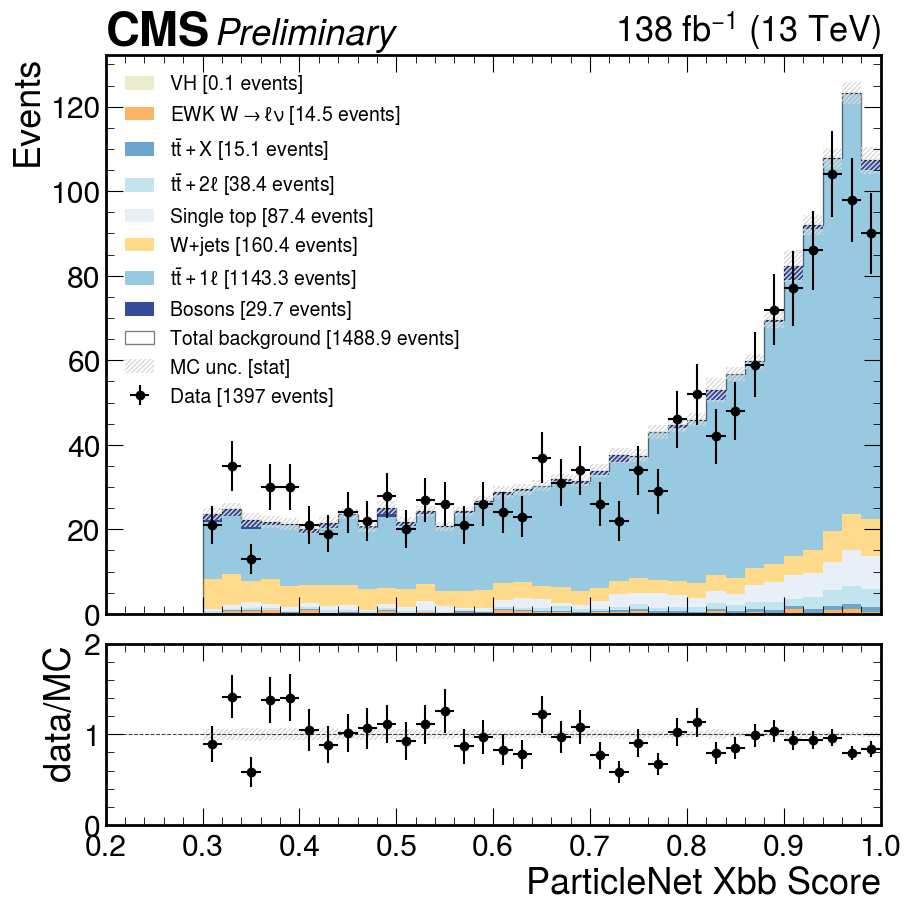

In [29]:
axes, _ = vbswh.plot_data_vs_mc(
    "hbbjet_score", bins=np.linspace(0.2, 1.0, 41), 
    selection="presel and hbbjet_msoftdrop >= 150",
    x_label=r"ParticleNet Xbb Score",
#     norm=True,
    stacked=True, autoblind=False
)

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/main/val/hbbjet_msoftdrop_data_vs_mc_presel_and_hbbjet_msoftdrop_geq_150.pdf


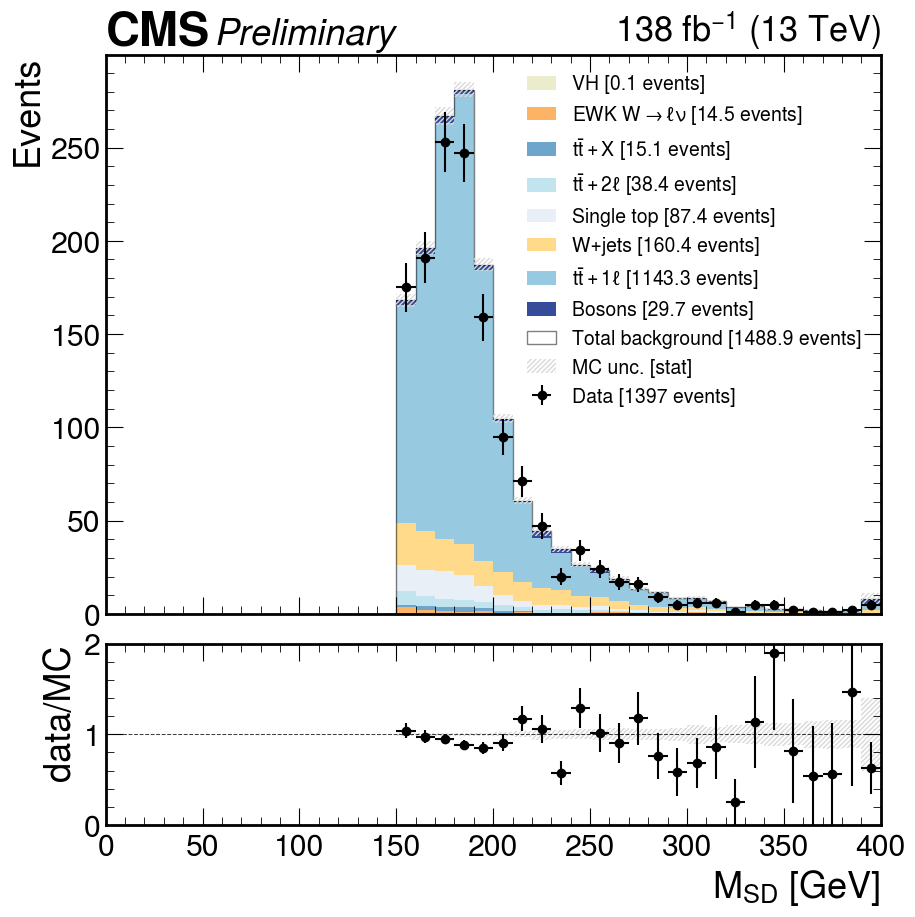

In [30]:
axes, _ = vbswh.plot_data_vs_mc(
    "hbbjet_msoftdrop", bins=np.linspace(0, 400, 41), 
    selection="presel and hbbjet_msoftdrop >= 150",
    x_label=r"$M_{SD}$ [GeV]",
#     norm=True,
    stacked=True, autoblind=False
)

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/main/val/ST_data_vs_mc_presel_noDetaJJ_and_abs_deta_jj_leq_3.pdf


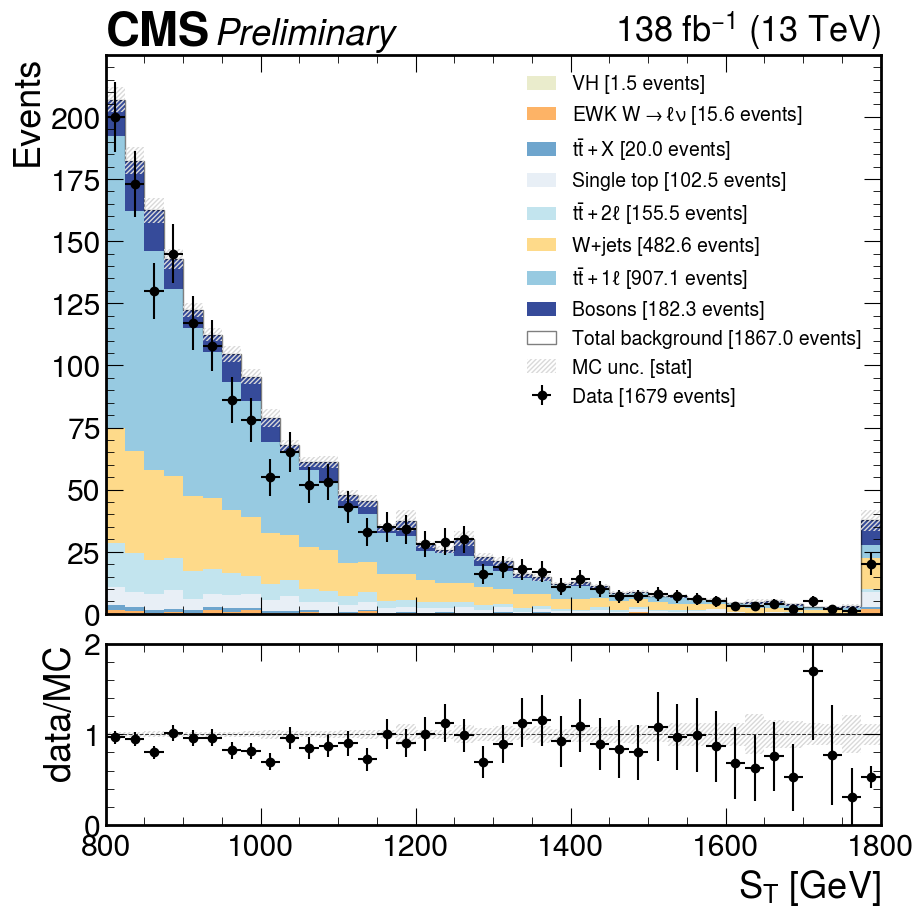

In [31]:
axes, _ = vbswh.plot_data_vs_mc(
    "ST", bins=np.linspace(800, 1800, 41), 
    selection="presel_noDetaJJ and abs_deta_jj <= 3",
    x_label=r"$S_T$ [GeV]",
#     norm=True,
    stacked=True, autoblind=False,
#     logy=True
)
# axes.set_yscale("log", nonpositive='clip')
# axes.set_ylim(bottom=0.1)

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/main/val/ST_data_vs_mc_presel_and_hbbjet_msoftdrop_geq_150.pdf


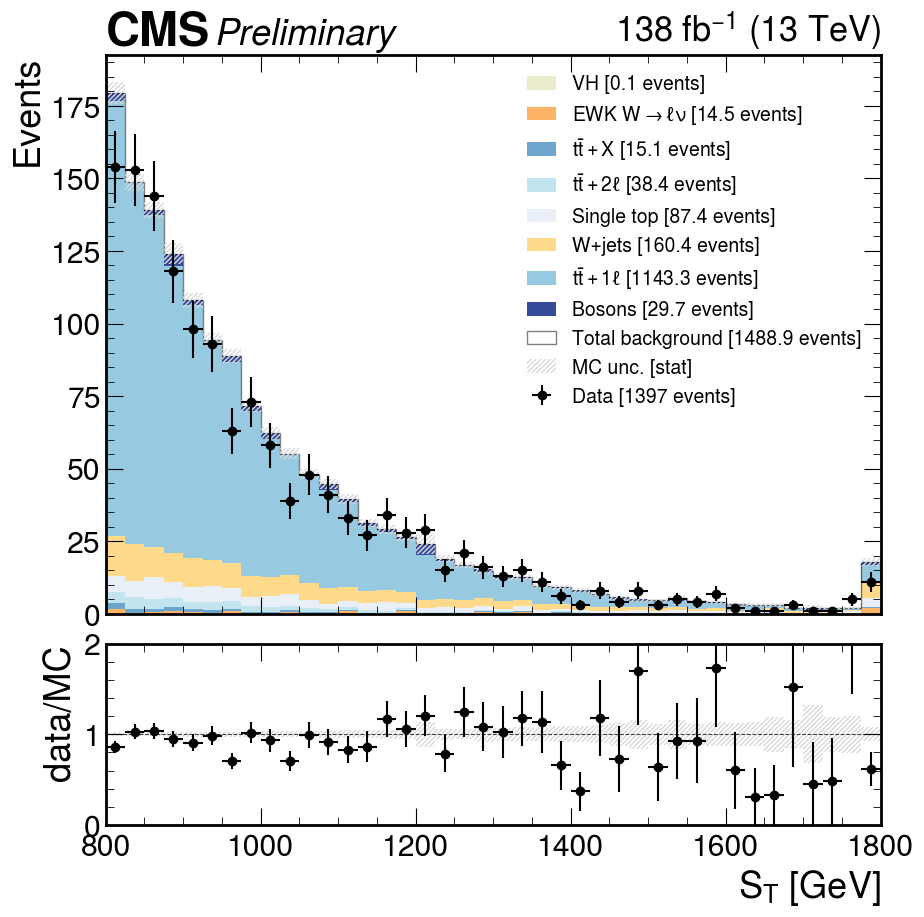

In [32]:
axes, _ = vbswh.plot_data_vs_mc(
    "ST", bins=np.linspace(800, 1800, 41), 
    selection="presel and hbbjet_msoftdrop >= 150",
    x_label=r"$S_T$ [GeV]",
#     norm=True,
    stacked=True, autoblind=False,
#     logy=True
)
# axes.set_yscale("log", nonpositive='clip')
# axes.set_ylim(bottom=0.1)

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/main/val/lep_pt_data_vs_mc_presel_and_hbbjet_msoftdrop_geq_150_and_abs_deta_jj_gt_4_and_hbbjet_score_gt_0p9.pdf


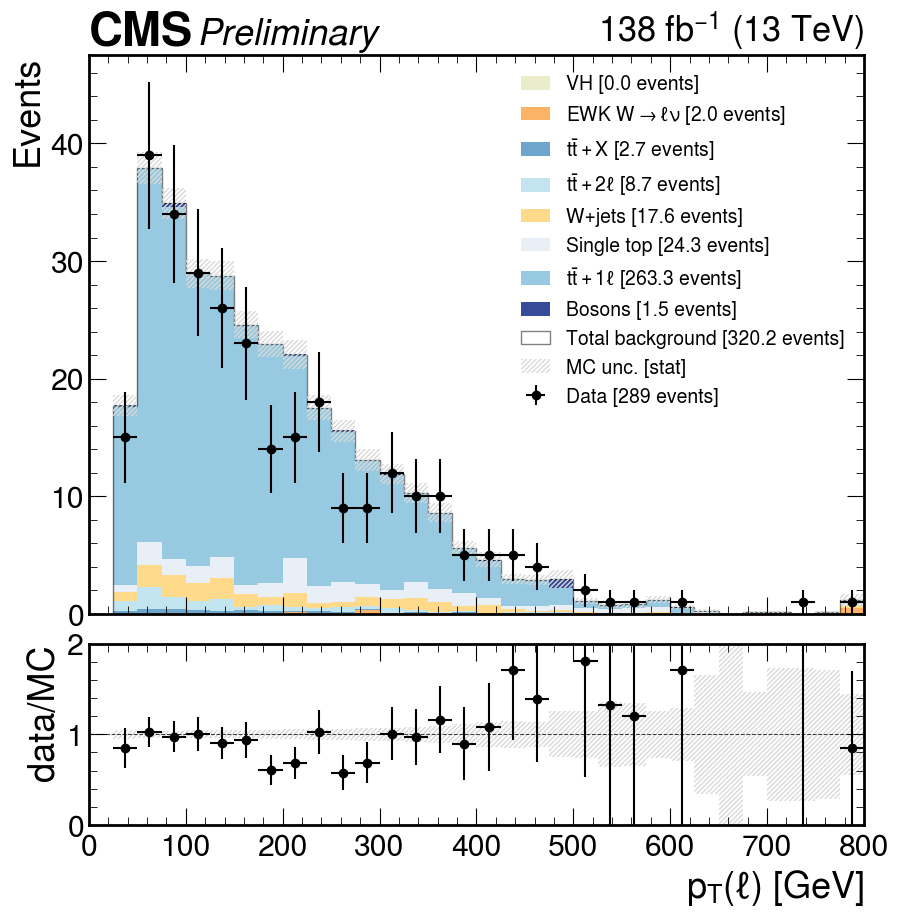

In [33]:
axes, _ = vbswh.plot_data_vs_mc(
    "lep_pt", bins=np.linspace(0, 800, 33), 
    selection="presel and hbbjet_msoftdrop >= 150 and abs_deta_jj > 4 and hbbjet_score > 0.9",
    x_label=r"$p_T(\ell)$ [GeV]",
#     norm=True,
    stacked=True, autoblind=False,
#     logy=True
)

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/main/val/MET_data_vs_mc_presel_and_hbbjet_msoftdrop_geq_150_and_abs_deta_jj_gt_4_and_hbbjet_score_gt_0p9.pdf


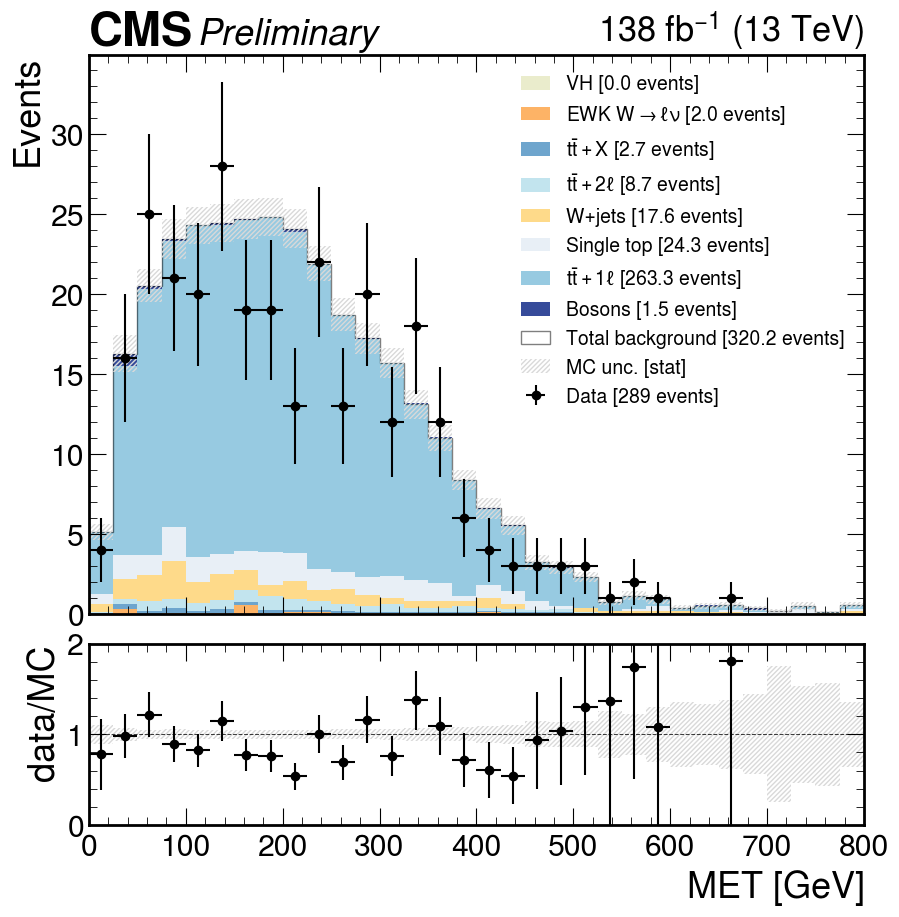

In [34]:
axes, _ = vbswh.plot_data_vs_mc(
    "MET", bins=np.linspace(0, 800, 33), 
    selection="presel and hbbjet_msoftdrop >= 150 and abs_deta_jj > 4 and hbbjet_score > 0.9",
    x_label=r"$MET$ [GeV]",
#     norm=True,
    stacked=True, autoblind=False,
#     logy=True
)

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/main/val/hbbjet_phi_data_vs_mc_regionA.pdf


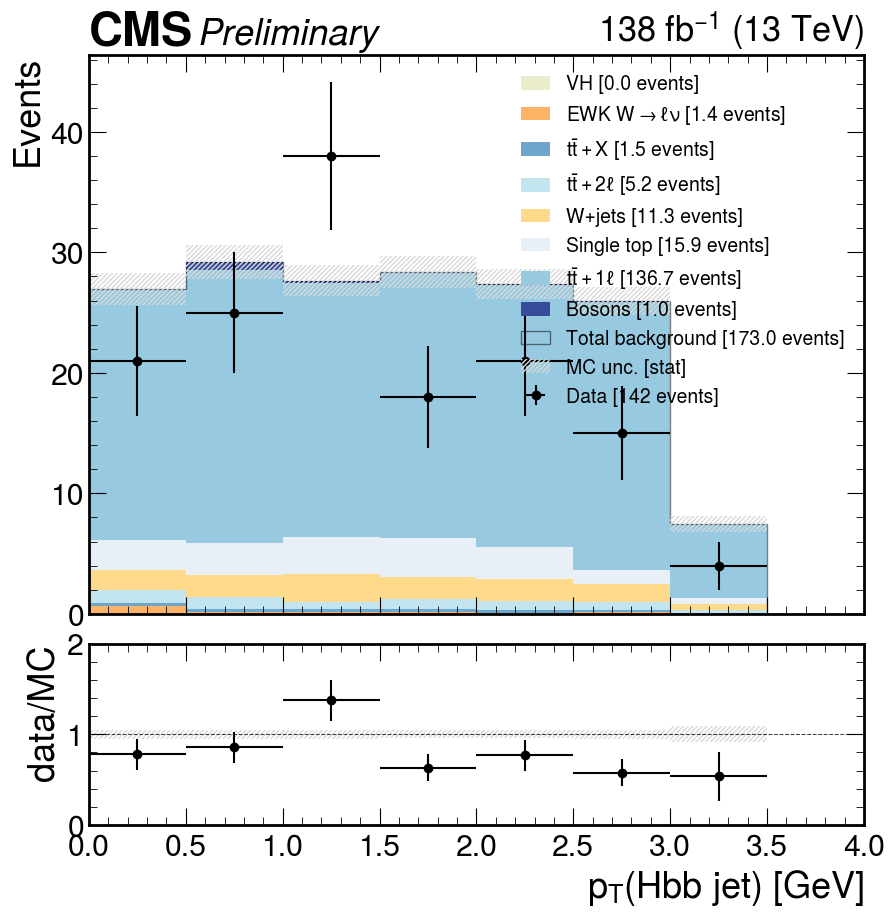

In [35]:
axes, _ = vbswh.plot_data_vs_mc(
    "hbbjet_phi", bins=np.linspace(0, 4, 9), 
    selection="regionA",
    x_label=r"$p_T($Hbb jet$)$ [GeV]",
#     norm=True,
    stacked=True, autoblind=False,
#     logy=True
    transf=abs
)

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/main/val/hbbjet_phi_data_vs_mc_presel_and_hbbjet_msoftdrop_geq_150_and_hbbjet_score_gt_0p9.pdf


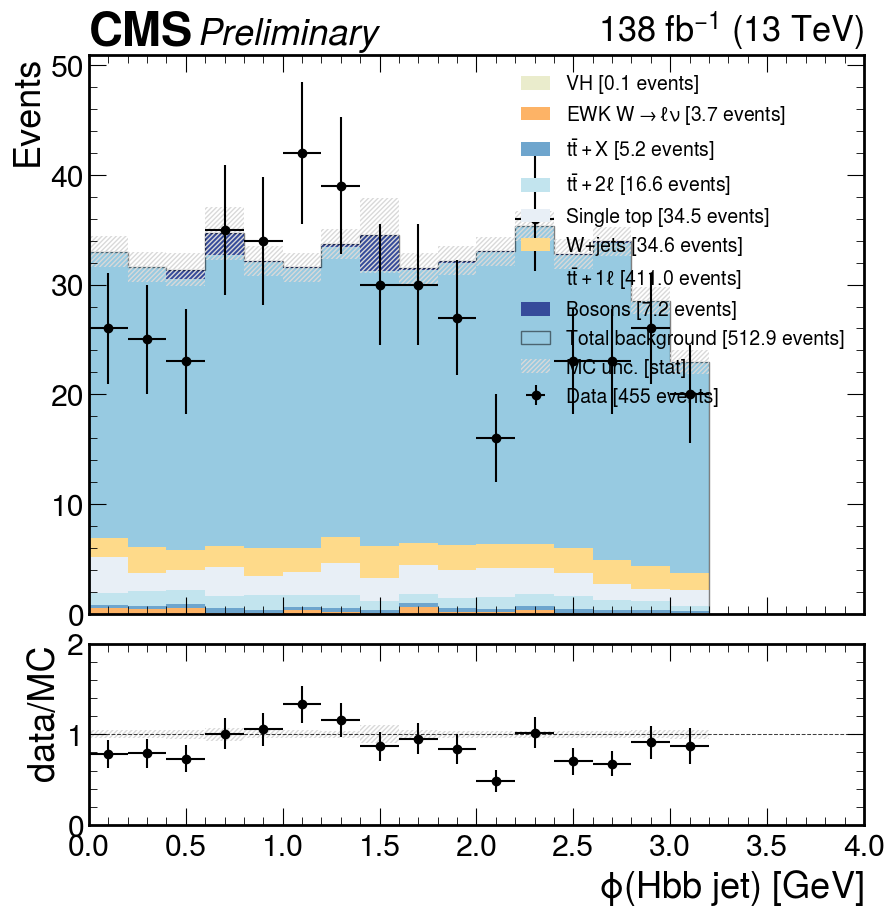

In [36]:
axes, _ = vbswh.plot_data_vs_mc(
    "hbbjet_phi", bins=np.linspace(0, 4, 21), 
    selection="presel and hbbjet_msoftdrop >= 150 and hbbjet_score > 0.9",
    x_label=r"$\phi($Hbb jet$)$ [GeV]",
#     norm=True,
    stacked=True, autoblind=False,
#     logy=True
    transf=abs
)

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/main/val/hbbjet_pt_data_vs_mc_presel_and_hbbjet_msoftdrop_geq_150_and_abs_deta_jj_gt_4_and_hbbjet_score_gt_0p9.pdf


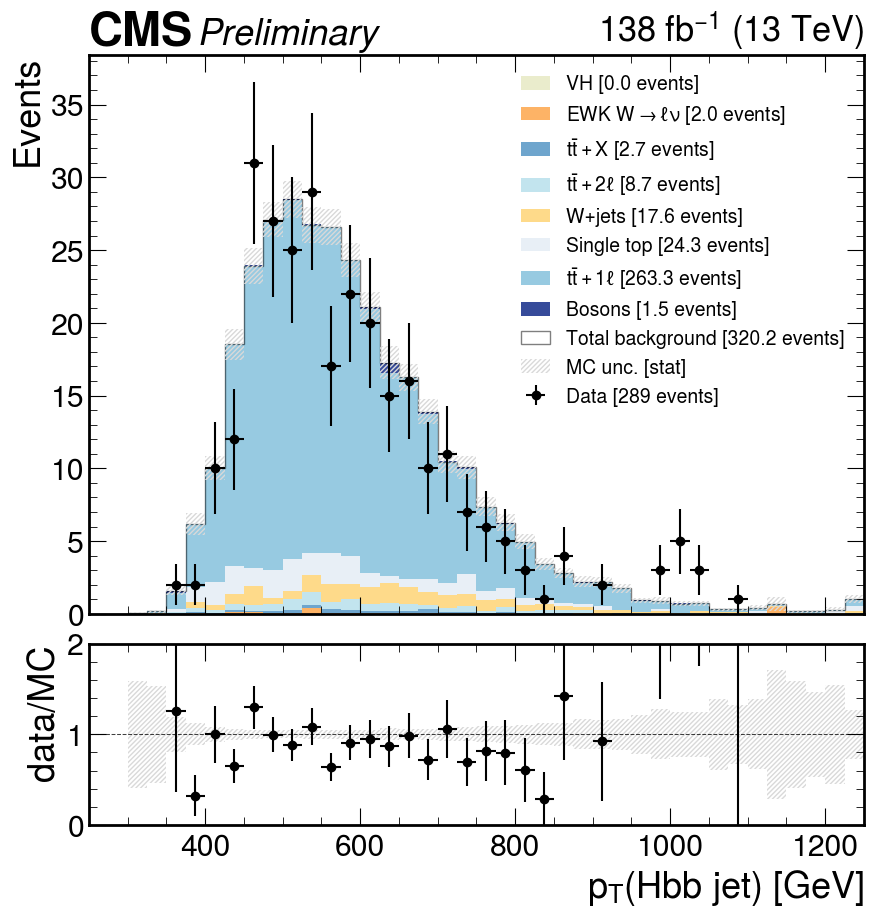

In [37]:
axes, _ = vbswh.plot_data_vs_mc(
    "hbbjet_pt", bins=np.linspace(250, 1250, 41), 
    selection="presel and hbbjet_msoftdrop >= 150 and abs_deta_jj > 4 and hbbjet_score > 0.9",
    x_label=r"$p_T($Hbb jet$)$ [GeV]",
#     norm=True,
    stacked=True, autoblind=False,
#     logy=True
)

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/main/val/hbbjet_score_data_vs_mc_presel_and_hbbjet_msoftdrop_geq_150_and_abs_deta_jj_gt_4.pdf


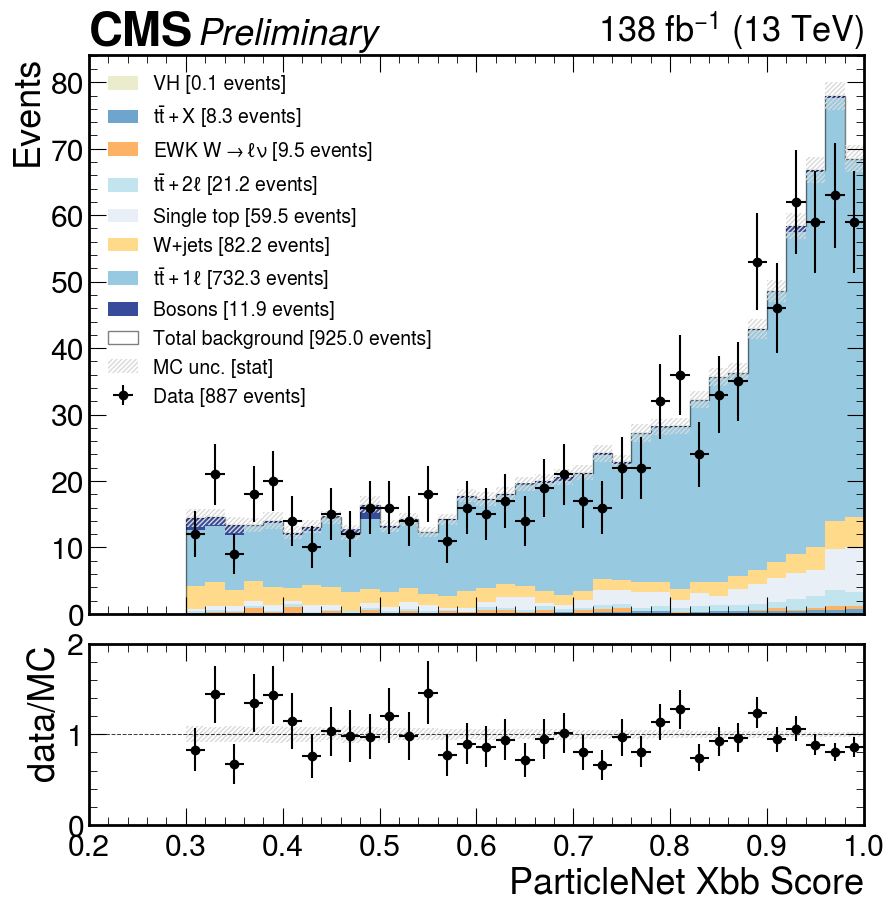

In [38]:
axes, _ = vbswh.plot_data_vs_mc(
    "hbbjet_score", bins=np.linspace(0.2, 1.0, 41), 
    selection="presel and hbbjet_msoftdrop >= 150 and abs_deta_jj > 4",
    x_label=r"ParticleNet Xbb Score",
#     norm=True,
    stacked=True, autoblind=False
)